# Context:

The bot analysis workbook is conceptually divided into two parts. 
The first part used a generalized approach to identify the bot traffic. 
The `IsolationForest` model was chosen for its simplicity, which allowed it to easily process the high volume of data and spot animosities.

`IsolationForest`Docs:
- https://en.wikipedia.org/wiki/Isolation_forest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

The goal for the second part is supposed to address Joe's and my efforts to identify the 'footprint' of bad sessions and 
Craft a combination session dimension that can be put in dbt config to filter the traffic.

To do this, the `IsolationForest` is not enough, as the model struggles with varying densities,i.e., it does not respect well the dominance of the US traffic or Direct over Paid Search

# Set up and imports

In [263]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [270]:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

try:
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.ensemble import IsolationForest
    from sklearn.compose import ColumnTransformer
    print("All required sklearn modules are available")
except ImportError as e:
    print(f"Import error: {e}")

scikit-learn version: 1.6.1
All required sklearn modules are available


# Data export 

We need to run the query in the warehouse, e.g.

https://console.cloud.google.com/bigquery?sq=513874015112:0ec1711743c347349bb3ac5d84926548

In [ ]:
import dask
import dask.dataframe as dd
import gcsfs
import pyarrow.parquet as pq
import pandas as pd


gcs_path = 'gs://bigquery_data_transfer_bt/bot/traffic_data-*.parquet'
fs = gcsfs.GCSFileSystem()

# The template function to read a single Parquet file using pyarrow
def read_parquet_file(file):
    with fs.open(file, 'rb') as f:
        table = pq.read_table(f)
        return table.to_pandas()

# Get a list of all files
files = fs.glob(gcs_path)

# Use Dask to delay reading each file in an iterative manner
df_list = [dask.delayed(read_parquet_file)(file) for file in files]

# Convert the list of delayed objects into a Dask data frame
dask_df = dd.from_delayed(df_list)

# Dask now reads files in parallel when compute() is called
final_df = dask_df.compute()


print(final_df.head(5))

**Inactive code placeholder**

import gcsfs
import os

gcs_path = 'gs://bigquery_data_transfer_bt/bot/traffic_data-*.parquet'
fs = gcsfs.GCSFileSystem()
files = fs.glob(gcs_path)

df_list = []
for file in files:
    df = pd.read_parquet(f'gs://{file}', engine='pyarrow', filesystem=fs)
    df_list.append(df)

final_df = pd.concat(df_list, ignore_index=True)

print(final_df.head(5))

# Exploratory data analysis

In [265]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41028807 entries, 0 to 41028806
Data columns (total 12 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   date                      object
 1   year_month                object
 2   sessions                  int64 
 3   last_touch_channel        object
 4   country                   object
 5   city                      object
 6   visitor_type              object
 7   device_category           object
 8   device_operating_system   object
 9   device_browser            object
 10  device_browser_version    object
 11  device_screen_resolution  object
dtypes: int64(1), object(11)
memory usage: 3.7+ GB


In [266]:
final_df['date'].size

41028807

In [267]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41028807 entries, 0 to 41028806
Data columns (total 12 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   date                      object
 1   year_month                object
 2   sessions                  int64 
 3   last_touch_channel        object
 4   country                   object
 5   city                      object
 6   visitor_type              object
 7   device_category           object
 8   device_operating_system   object
 9   device_browser            object
 10  device_browser_version    object
 11  device_screen_resolution  object
dtypes: int64(1), object(11)
memory usage: 3.7+ GB


In [268]:
print(f"Data frame size: {final_df.shape}")
print("\nColumns available: ", final_df.columns.tolist())

Data frame size: (41028807, 12)

Columns available:  ['date', 'year_month', 'sessions', 'last_touch_channel', 'country', 'city', 'visitor_type', 'device_category', 'device_operating_system', 'device_browser', 'device_browser_version', 'device_screen_resolution']


# Slicing data to TOP 10 countries and running bot identification process

In [169]:
# Focus only on TOP 10 largest country contributors to traffic
top_n = 10
total_sessions = final_df.groupby('country')['sessions'].sum().sort_values(ascending=False)
top_countries = total_sessions.head(top_n).index.tolist()

In [170]:
print(f"\nTop {top_n} countries by total sessions:\n")
for country, sessions in total_sessions.head(top_n).items():
    print(f"{country}: {sessions:,}")


Top 10 countries by total sessions:

United States: 5,376,116
India: 1,469,758
Canada: 813,566
United Kingdom: 583,023
Australia: 482,971
Japan: 461,307
Brazil: 399,437
Germany: 309,272
France: 269,385
Philippines: 238,694


In [171]:
# Slice data to focus on TOP only
df_top = final_df[final_df['country'].isin(top_countries)]

In [172]:
# Current approach: Country + Time dimension
country_time_metrics = df_top.groupby(['country', 'year_month']).agg({
    'sessions': ['sum', 'mean', 'std', 'count'],
    'last_touch_channel': ['nunique', 'count'],
    'device_category': 'nunique'
}).reset_index()

# Flatten column names
country_time_metrics.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col 
                              for col in country_time_metrics.columns]

# Features at country + time level
country_time_metrics['session_intensity_by_time'] = (
    country_time_metrics['sessions_sum'] / country_time_metrics['sessions_count']
)
country_time_metrics['channel_diversity_by_time'] = (
    country_time_metrics['last_touch_channel_nunique'] / country_time_metrics['last_touch_channel_count']
)

# Add variability metric
country_time_metrics['session_variability_by_time'] = (
    country_time_metrics['sessions_std'] / country_time_metrics['sessions_mean']
).fillna(0)

# Country-only metrics
country_metrics = df_top.groupby(['country']).agg({
    'sessions': ['sum', 'mean', 'std', 'count'],
    'last_touch_channel': ['nunique', 'count'],
    'device_category': 'nunique'
}).reset_index()

# Flatten column names
country_metrics.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col 
                         for col in country_metrics.columns]

In [173]:
# Features at country level only
country_metrics['session_intensity_country'] = (
    country_metrics['sessions_sum'] / country_metrics['sessions_count']
)
country_metrics['channel_diversity_country'] = (
    country_metrics['last_touch_channel_nunique'] / country_metrics['last_touch_channel_count']
)
country_metrics['session_variability_country'] = (
    country_metrics['sessions_std'] / country_metrics['sessions_mean']
).fillna(0)

In [174]:
for col in country_time_metrics.columns:
    print(col)

country_
year_month_
sessions_sum
sessions_mean
sessions_std
sessions_count
last_touch_channel_nunique
last_touch_channel_count
device_category_nunique
session_intensity_by_time
channel_diversity_by_time
session_variability_by_time


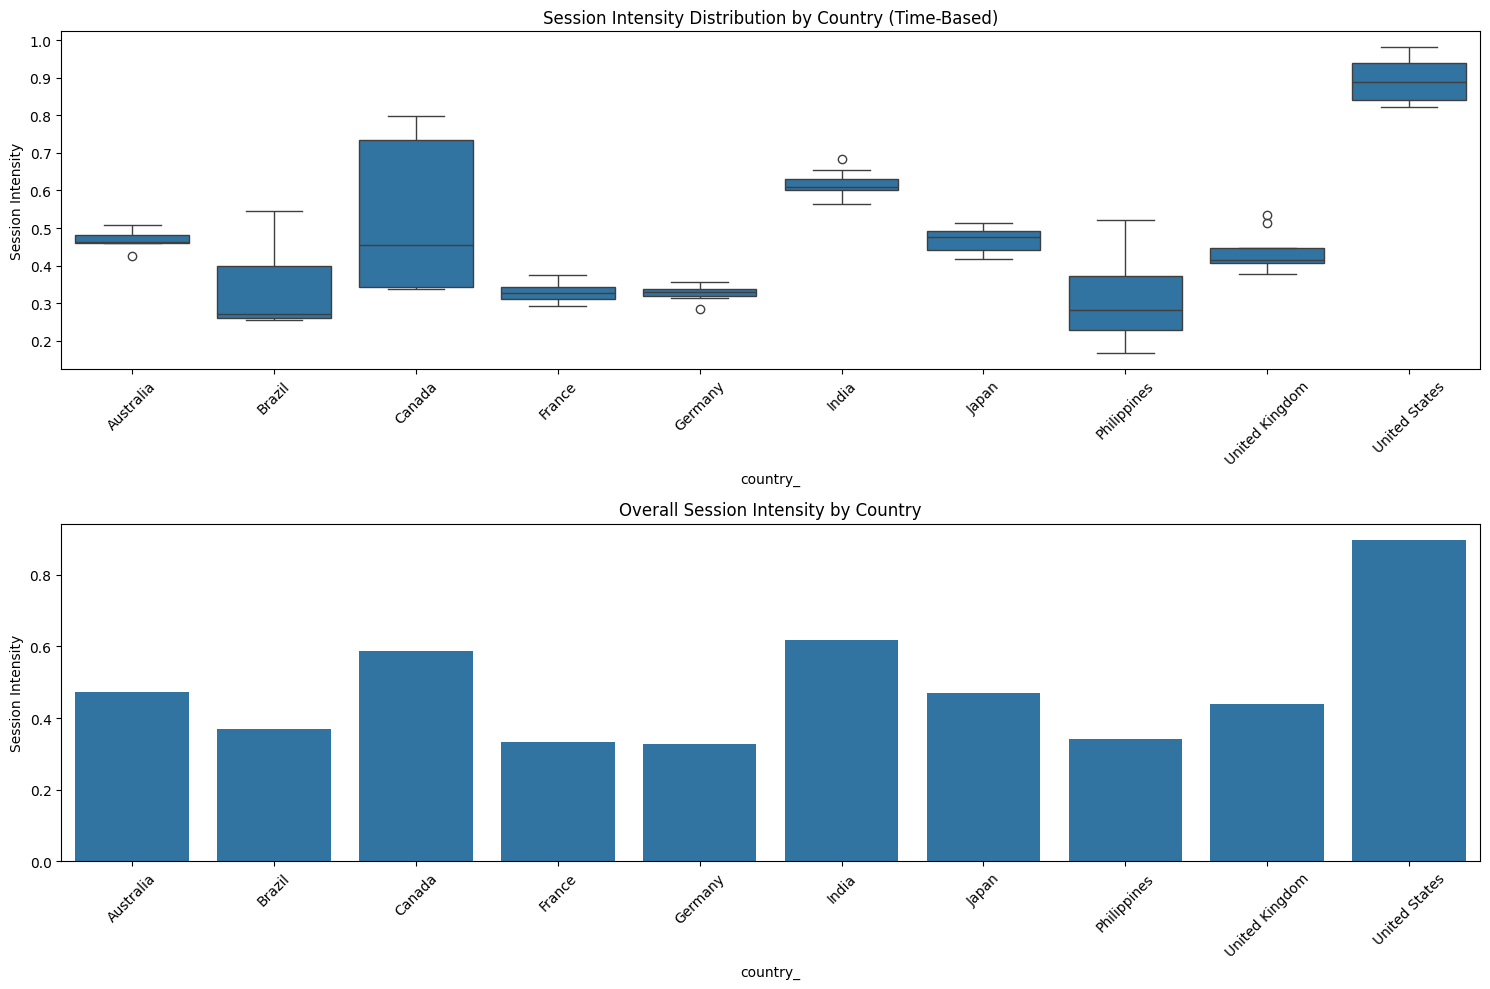

In [176]:
# Visualizations
plt.figure(figsize=(15, 10))

# Session Intensity Comparison
plt.subplot(2, 1, 1)
sns.boxplot(data=country_time_metrics, x='country_', y='session_intensity_by_time')
plt.title('Session Intensity Distribution by Country (Time-Based)')
plt.xticks(rotation=45)
plt.ylabel('Session Intensity')

plt.subplot(2, 1, 2)
sns.barplot(data=country_metrics, x='country_', y='session_intensity_country')
plt.title('Overall Session Intensity by Country')
plt.xticks(rotation=45)
plt.ylabel('Session Intensity')
plt.tight_layout()
plt.show()

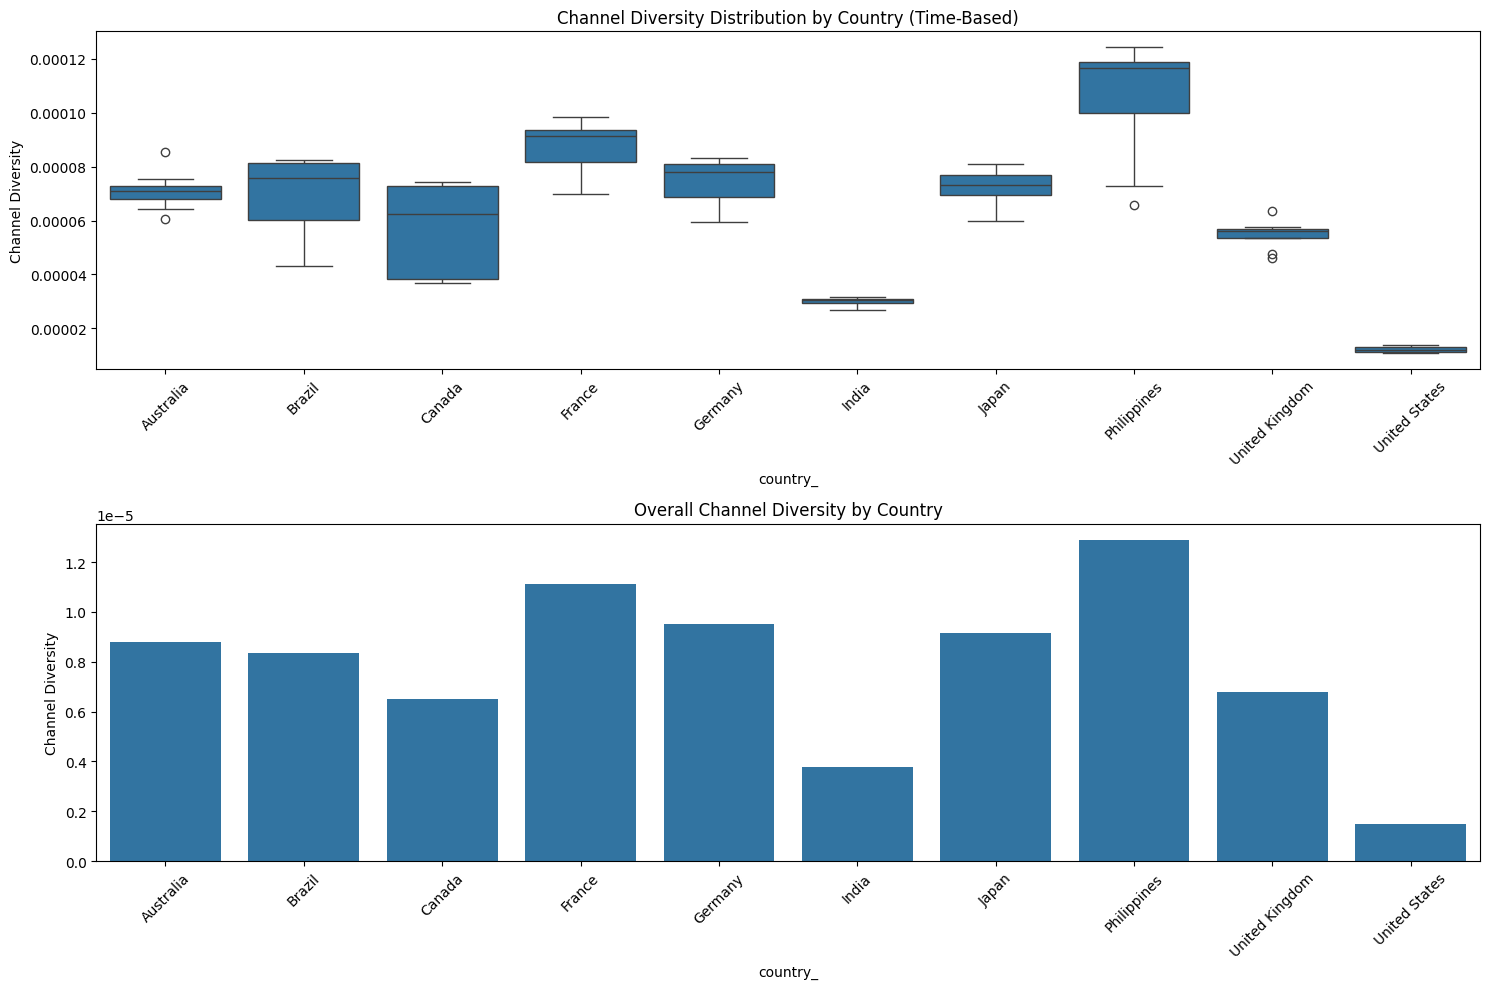

In [177]:
# Channel Diversity Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.boxplot(data=country_time_metrics, x='country_', y='channel_diversity_by_time')
plt.title('Channel Diversity Distribution by Country (Time-Based)')
plt.xticks(rotation=45)
plt.ylabel('Channel Diversity')

plt.subplot(2, 1, 2)
sns.barplot(data=country_metrics, x='country_', y='channel_diversity_country')
plt.title('Overall Channel Diversity by Country')
plt.xticks(rotation=45)
plt.ylabel('Channel Diversity')
plt.tight_layout()
plt.show()

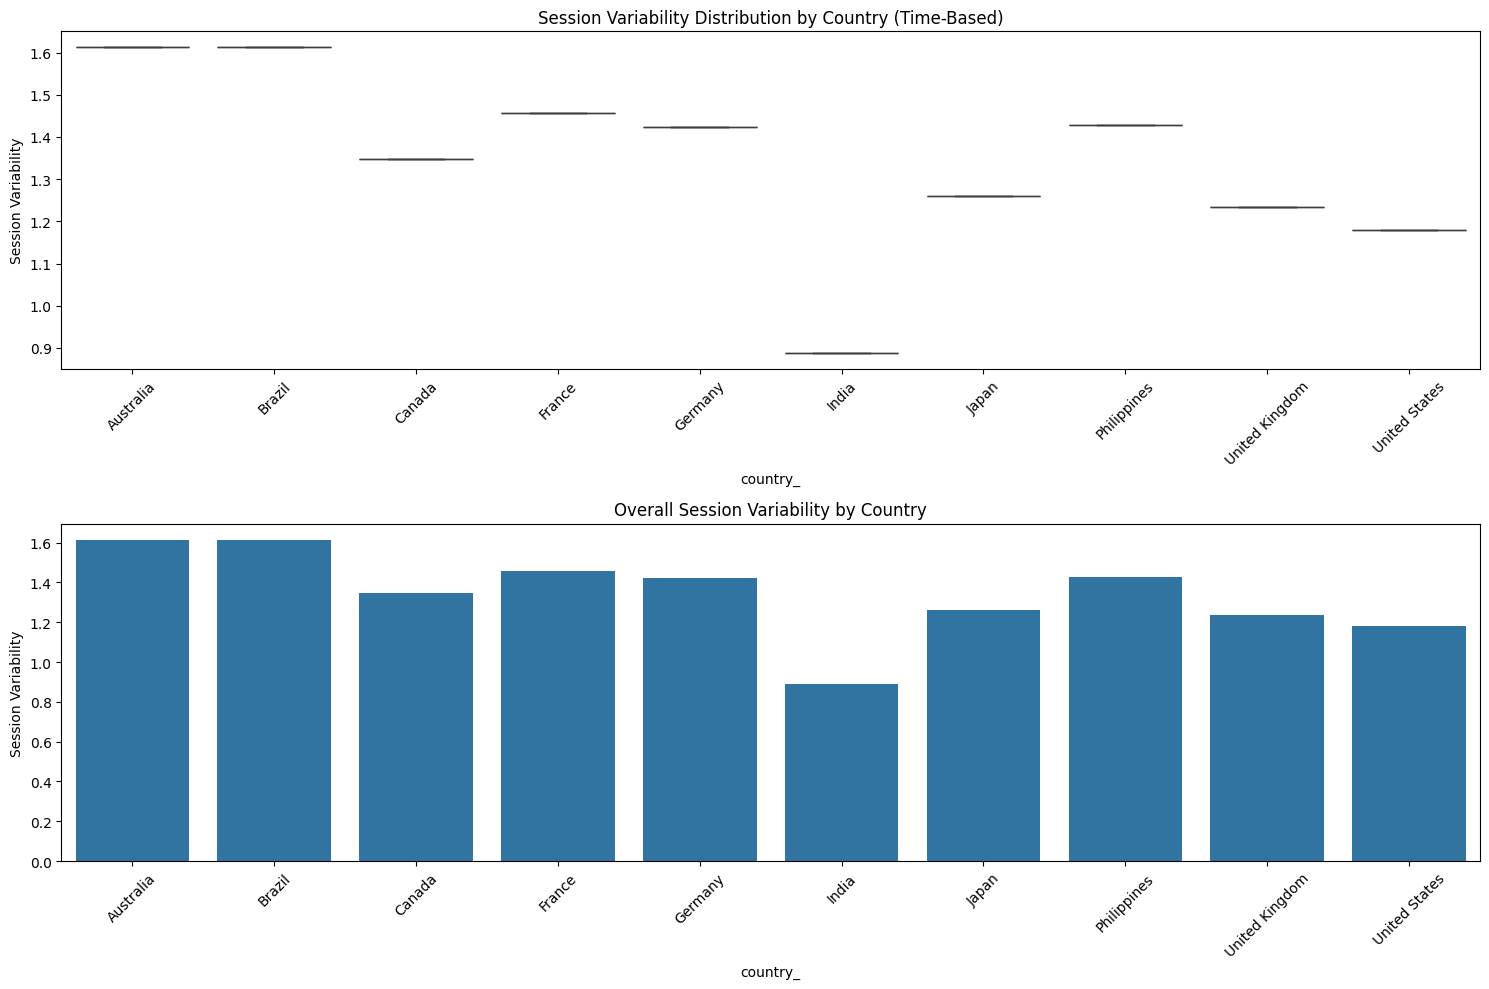

In [125]:
# Session Variability Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.boxplot(data=country_time_metrics, x='country_', y='session_variability_by_time')
plt.title('Session Variability Distribution by Country (Time-Based)')
plt.xticks(rotation=45)
plt.ylabel('Session Variability')

plt.subplot(2, 1, 2)
sns.barplot(data=country_metrics, x='country_', y='session_variability_country')
plt.title('Overall Session Variability by Country')
plt.xticks(rotation=45)
plt.ylabel('Session Variability')
plt.tight_layout()
plt.show()

In [178]:
# Print detailed comparison for first country
example_country = top_countries[0]
print(f"\nDetailed comparison for {example_country}:")

print("\nTime-based metrics:")
time_metrics = country_time_metrics[country_time_metrics['country_'] == example_country][
    ['year_month_', 'session_intensity_by_time', 'channel_diversity_by_time', 'session_variability_by_time']
].head()
print(time_metrics)


Detailed comparison for United States:

Time-based metrics:
   year_month_  session_intensity_by_time  channel_diversity_by_time  \
72  2023-10-01                   0.931669                   0.000011   
73  2023-11-01                   0.960423                   0.000011   
74  2023-12-01                   0.916263                   0.000012   
75  2024-01-01                   0.982740                   0.000011   
76  2024-02-01                   0.843439                   0.000014   

    session_variability_by_time  
72                     1.643523  
73                     1.847698  
74                     1.647042  
75                     7.082640  
76                     1.582677  


In [179]:
# Select features for bot detection
bot_detection_features = [
    'sessions_sum',
    'session_intensity_by_time',
    'channel_diversity_by_time',
    'session_variability_by_time',
    'device_category_nunique'
]

In [180]:
# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(country_time_metrics[bot_detection_features])

# Apply Isolation Forest for anomaly detection
isolation_forest = IsolationForest(
    contamination=0.1,  # Expected proportion of anomalies
    random_state=42,
    n_jobs=-1
)

In [181]:
# Detect anomalies
country_time_metrics['is_bot'] = isolation_forest.fit_predict(features_scaled) == -1
country_time_metrics['anomaly_score'] = -isolation_forest.score_samples(features_scaled)

In [182]:
# Print overall bot detection results
print("Bot Detection Results:")
print(f"Total periods analyzed: {len(country_time_metrics)}")
print(f"Periods flagged as bots: {country_time_metrics['is_bot'].sum()}")
print(f"Bot percentage: {(country_time_metrics['is_bot'].mean() * 100):.2f}%")

Bot Detection Results:
Total periods analyzed: 80
Periods flagged as bots: 8
Bot percentage: 10.00%


In [183]:
# Analyze bot distribution by country
bot_by_country = country_time_metrics.groupby('country_').agg({
    'is_bot': ['count', 'sum', 'mean'],
    'anomaly_score': 'mean'
}).round(3)

bot_by_country = bot_by_country.sort_values(('anomaly_score', 'mean'), ascending=False)

print("\nBot Activity by Country (Sorted by Anomaly Score):")
print(bot_by_country)


Bot Activity by Country (Sorted by Anomaly Score):
               is_bot            anomaly_score
                count sum   mean          mean
country_                                      
United States       8   5  0.625         0.606
Philippines         8   2  0.250         0.515
India               8   0  0.000         0.492
United Kingdom      8   0  0.000         0.460
Australia           8   1  0.125         0.444
Canada              8   0  0.000         0.438
Brazil              8   0  0.000         0.428
Japan               8   0  0.000         0.416
France              8   0  0.000         0.408
Germany             8   0  0.000         0.393


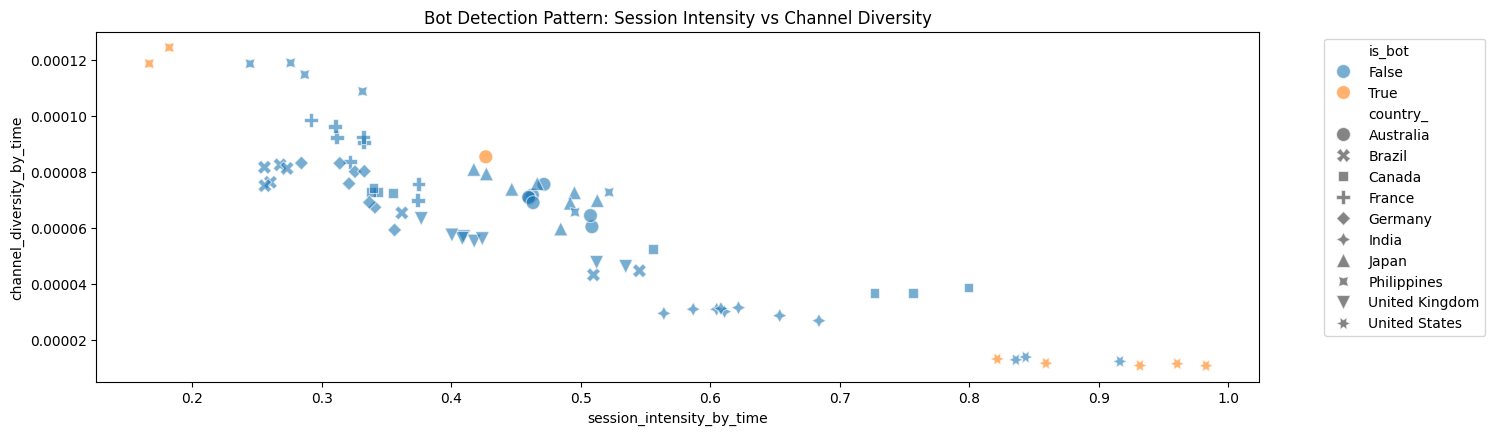

In [184]:
# Visualize bot patterns
plt.figure(figsize=(15, 10))

# Plot 1: Session Intensity vs Channel Diversity colored by bot detection
plt.subplot(2, 1, 1)
sns.scatterplot(
    data=country_time_metrics,
    x='session_intensity_by_time',
    y='channel_diversity_by_time',
    hue='is_bot',
    style='country_',
    s=100,
    alpha=0.6
)
plt.title('Bot Detection Pattern: Session Intensity vs Channel Diversity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

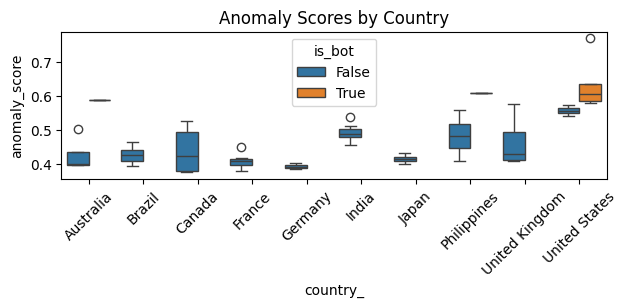

In [185]:
# Plot 2: Anomaly Scores by Country
plt.subplot(2, 1, 2)
sns.boxplot(
    data=country_time_metrics,
    x='country_',
    y='anomaly_score',
    hue='is_bot'
)
plt.title('Anomaly Scores by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

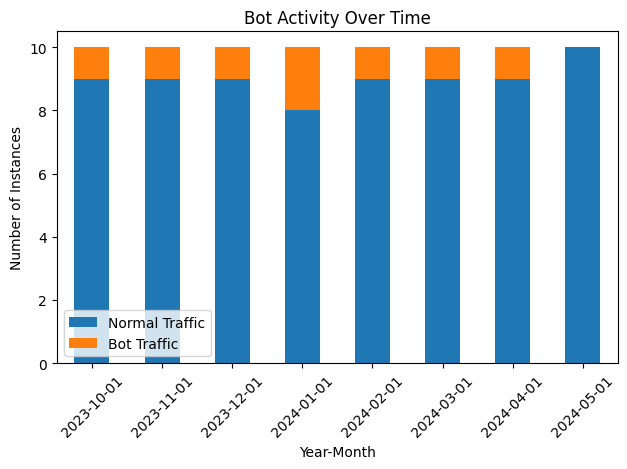

In [186]:
# Temporal analysis of bot activity
plt.figure(figsize=(15, 6))
bot_timeline = country_time_metrics.groupby(['year_month_', 'is_bot']).size().unstack()
bot_timeline.plot(kind='bar', stacked=True)
plt.title('Bot Activity Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Instances')
plt.legend(['Normal Traffic', 'Bot Traffic'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

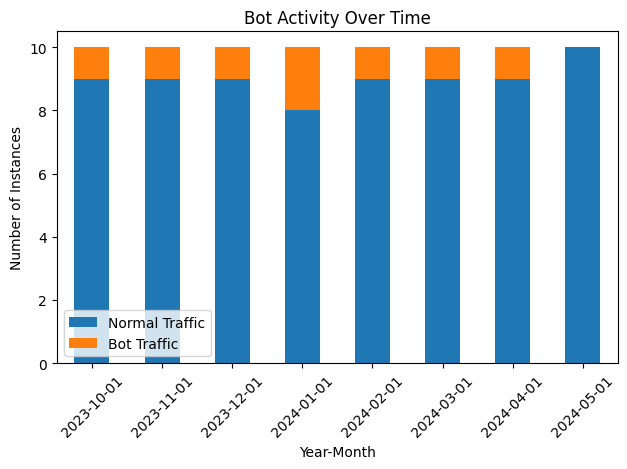


Bot Traffic Characteristics:

Top 10 Most Anomalous Periods:
         country_ year_month_  sessions_sum  session_intensity_by_time  channel_diversity_by_time  anomaly_score
75  United States  2024-01-01        820486                   0.982740                   0.000011       0.770388
73  United States  2023-11-01        752986                   0.960423                   0.000011       0.634952
60    Philippines  2024-02-01         11230                   0.166652                   0.000119       0.610182
59    Philippines  2024-01-01         13169                   0.182139                   0.000124       0.608798
72  United States  2023-10-01        773591                   0.931669                   0.000011       0.605914
2       Australia  2023-12-01         44942                   0.426532                   0.000085       0.588339
77  United States  2024-03-01        561738                   0.821573                   0.000013       0.586132
78  United States  2024-04-01     

In [191]:
# Temporal analysis of bot activity
plt.figure(figsize=(15, 6))
bot_timeline = country_time_metrics.groupby(['year_month_', 'is_bot']).size().unstack()
bot_timeline.plot(kind='bar', stacked=True)
plt.title('Bot Activity Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Instances')
plt.legend(['Normal Traffic', 'Bot Traffic'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify specific bot characteristics
bot_traffic = country_time_metrics[country_time_metrics['is_bot']]
print("\nBot Traffic Characteristics:")
print("\nTop 10 Most Anomalous Periods:")
top_anomalies = bot_traffic.nlargest(10, 'anomaly_score')
print(top_anomalies[['country_', 'year_month_', 'sessions_sum', 
                     'session_intensity_by_time', 'channel_diversity_by_time', 
                     'anomaly_score']].to_string())

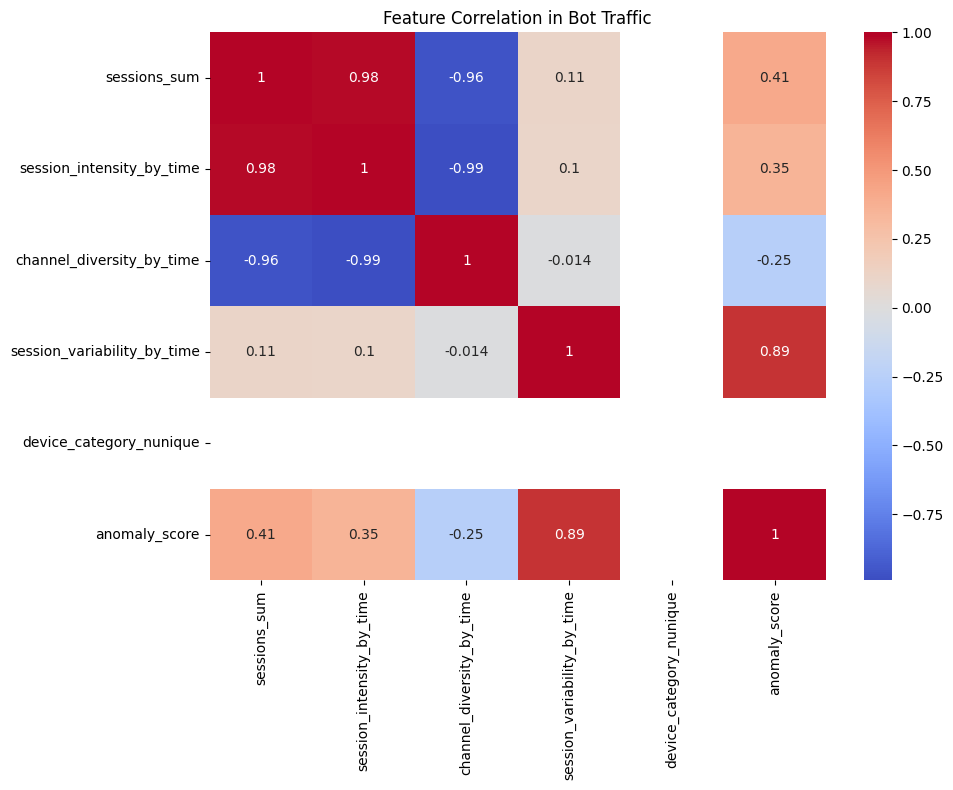

In [190]:
# Calculate correlation between features for bot traffic
bot_feature_correlation = bot_traffic[bot_detection_features + ['anomaly_score']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(bot_feature_correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation in Bot Traffic')
plt.tight_layout()
plt.show()

# Export bot detection results if needed
# bot_traffic.to_csv('bot_detection_results.csv', index=False)

# Distillation of bot' sessions characteristics

In [192]:
print(f"scikit-learn version: {sklearn.__version__}")

try:
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.svm import OneClassSVM
    from sklearn.cluster import DBSCAN    
    print("All required sklearn modules are available")
except ImportError as e:
    print(f"Import error: {e}")

scikit-learn version: 1.6.1
All required sklearn modules are available


In [208]:
df_col = sorted(final_df.columns.tolist())
df_col

['city',
 'country',
 'date',
 'device_browser',
 'device_browser_version',
 'device_category',
 'device_operating_system',
 'device_screen_resolution',
 'last_touch_channel',
 'sessions',
 'visitor_type',
 'year_month']

In [220]:
country_traffic = final_df.groupby('country')['sessions'].sum().sort_values(ascending=False).reset_index()

total_sessions = country_traffic['sessions'].sum()
country_traffic['global_percentage'] = (country_traffic['sessions'] / total_sessions * 100).round(2)
country_traffic['cumulative_percentage'] = country_traffic['global_percentage'].cumsum()

country_traffic['tier'] = pd.cut(
    country_traffic['global_percentage'], 
    bins=[0, 1, 5, 20, 100], 
    labels=['Tier 4', 'Tier 3', 'Tier 2', 'Tier 1']
)

print("Country Traffic Distribution:")
print(country_traffic.head(20).to_string())

Country Traffic Distribution:
           country  sessions  global_percentage  cumulative_percentage    tier
0    United States   5376116              37.45                  37.45  Tier 1
1            India   1469758              10.24                  47.69  Tier 2
2           Canada    813566               5.67                  53.36  Tier 2
3   United Kingdom    583023               4.06                  57.42  Tier 3
4        Australia    482971               3.36                  60.78  Tier 3
5            Japan    461307               3.21                  63.99  Tier 3
6           Brazil    399437               2.78                  66.77  Tier 3
7          Germany    309272               2.15                  68.92  Tier 3
8           France    269385               1.88                  70.80  Tier 3
9      Philippines    238694               1.66                  72.46  Tier 3
10     Netherlands    153550               1.07                  73.53  Tier 3
11         Vietnam    

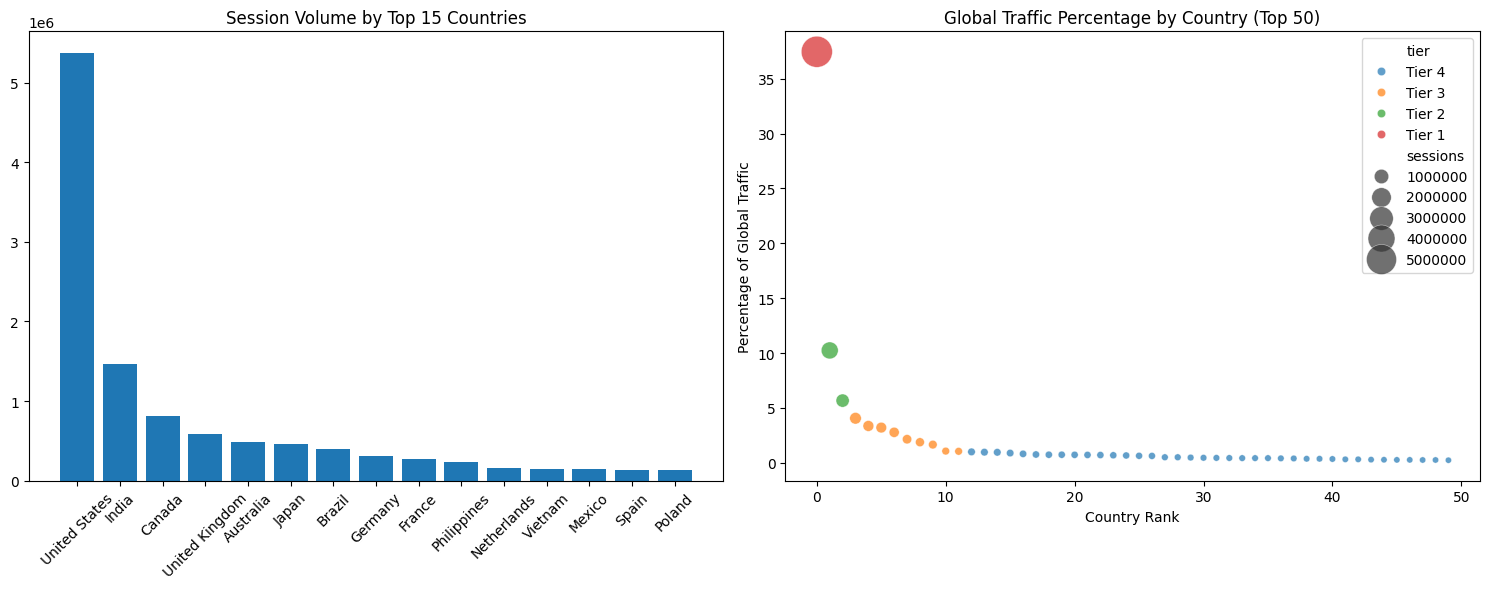

In [221]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(country_traffic['country'].head(15), country_traffic['sessions'].head(15))
plt.title('Session Volume by Top 15 Countries')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.scatterplot(
    data=country_traffic.head(50), 
    x=range(50), 
    y='global_percentage',
    hue='tier',
    size='sessions',
    sizes=(20, 500),
    alpha=0.7
)
plt.title('Global Traffic Percentage by Country (Top 50)')
plt.xlabel('Country Rank')
plt.ylabel('Percentage of Global Traffic')
plt.tight_layout()
plt.show()

In [230]:
def analyze_country_baselines(df):
    """Analyze the natural baseline distribution of traffic by country"""
    country_traffic = df.groupby('country')['sessions'].sum().sort_values(ascending=False).reset_index()
    
    # Calculate percentage of global traffic
    total_sessions = country_traffic['sessions'].sum()
    country_traffic['global_percentage'] = (country_traffic['sessions'] / total_sessions * 100).round(2)
    country_traffic['cumulative_percentage'] = country_traffic['global_percentage'].cumsum()
    
    # Identify country tiers
    country_traffic['tier'] = pd.cut(
        country_traffic['global_percentage'], 
        bins=[0, 1, 5, 20, 100], 
        labels=['Tier 4', 'Tier 3', 'Tier 2', 'Tier 1']
    )
    
    print("Country Traffic Distribution:")
    print(country_traffic.head(20).to_string())
    
    # Visualize traffic distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.bar(country_traffic['country'].head(15), country_traffic['sessions'].head(15))
    plt.title('Session Volume by Top 15 Countries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=country_traffic.head(50), 
        x=range(50), 
        y='global_percentage',
        hue='tier',
        size='sessions',
        sizes=(20, 500),
        alpha=0.7
    )
    plt.title('Global Traffic Percentage by Country (Top 50)')
    plt.xlabel('Country Rank')
    plt.ylabel('Percentage of Global Traffic')
    plt.tight_layout()
    plt.show()
    
    return country_traffic

In [253]:
# Step 2: Process data by country tier
# -----------------------------------
def prepare_tier_data(df, country_traffic):
    """Prepare data by country tier for anomaly detection with fixed column naming"""
    # Join country tier information with main data
    country_tier_map = dict(zip(country_traffic['country'], country_traffic['tier']))
    df_with_tier = df.copy()
    df_with_tier['country_tier'] = df_with_tier['country'].map(country_tier_map).fillna('Tier 4')
    
    # Process data by tier
    tier_data = {}
    
    for tier in df_with_tier['country_tier'].unique():
        tier_df = df_with_tier[df_with_tier['country_tier'] == tier]
        
        # Group by country and month
        tier_metrics = tier_df.groupby(['country', 'year_month']).agg({
            'sessions': ['sum', 'mean', 'std', 'count'],
            'last_touch_channel': 'nunique',
            'device_category': 'nunique'
        }).reset_index()
        
        new_columns = []
        for col in tier_metrics.columns:
            if isinstance(col, tuple):
                if col[1] == '':
                    # Preserve original names for grouping columns
                    new_columns.append(col[0])
                else:
                    # Only join with underscore for aggregated columns
                    new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append(col)
        
        tier_metrics.columns = new_columns
        
        tier_metrics['session_intensity'] = tier_metrics['sessions_sum'] / tier_metrics['sessions_count']
        tier_metrics['channel_diversity'] = tier_metrics['last_touch_channel_nunique'] / tier_metrics['sessions_count']
        tier_metrics['session_variability'] = (tier_metrics['sessions_std'] / tier_metrics['sessions_mean']).fillna(0)
        
        # Store processed data
        tier_data[tier] = tier_metrics
    
    return df_with_tier, tier_data


In [239]:
# Step 3: Ensemble anomaly detection by tier
# ----------------------------------------
def ensemble_anomaly_detection(tier_data):
    """Apply ensemble anomaly detection within each country tier"""
    # Features to use for anomaly detection
    features = [
        'session_intensity', 
        'channel_diversity',
        'session_variability',
        'device_category_nunique'
    ]
    
    # Tier-specific contamination rates
    contamination_rates = {
        'Tier 1': 0.05,
        'Tier 2': 0.075,
        'Tier 3': 0.1,
        'Tier 4': 0.15
    }
    
    # Store anomaly results
    anomaly_results = {}
    
    for tier, tier_metrics in tier_data.items():
        print(f"\nPerforming ensemble anomaly detection for {tier}...")
        
        # Scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(tier_metrics[features])
        
        # Contamination for this tier
        contamination = contamination_rates.get(tier, 0.1)
        
        # 1. Isolation Forest
        print("Running Isolation Forest...")
        isolation_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_jobs=-1
        )
        if_predictions = isolation_forest.fit_predict(features_scaled)
        if_scores = -isolation_forest.score_samples(features_scaled)
        
        # 2. Local Outlier Factor
        # Note: LOF needs special handling for scores
        print("Running Local Outlier Factor...")
        # First fit LOF in novelty=False mode for training
        lof_fit = LocalOutlierFactor(
            n_neighbors=20,
            contamination=contamination,
            novelty=False,
            n_jobs=-1
        )
        lof_predictions = lof_fit.fit_predict(features_scaled)
        
        # Since we can't directly get scores from LOF in this mode,
        # we'll use the negative of the factors as scores - higher is more anomalous
        # Get the raw negative outlier factors (-1 * factor)
        lof_scores = lof_fit.negative_outlier_factor_ * -1
        
        # 3. One-Class SVM
        print("Running One-Class SVM...")
        try:
            ocsvm = OneClassSVM(
                nu=contamination,
                kernel='rbf',
                gamma='scale'
            )
            ocsvm_predictions = ocsvm.fit_predict(features_scaled)
            ocsvm_scores = -ocsvm.decision_function(features_scaled)  # Use decision_function
        except Exception as e:
            print(f"OneClassSVM failed: {e}")
            ocsvm_predictions = np.zeros_like(if_predictions)
            ocsvm_scores = np.zeros_like(if_scores)
        
        # 4. DBSCAN (distance-based clustering)
        print("Running DBSCAN...")
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_clusters = dbscan.fit_predict(features_scaled)
        dbscan_predictions = np.ones_like(if_predictions)
        dbscan_predictions[dbscan_clusters == -1] = -1
        
        # Ensemble predictions (majority voting)
        ensemble_votes = np.vstack([
            if_predictions == -1,
            lof_predictions == -1,
            ocsvm_predictions == -1,
            dbscan_predictions == -1
        ]).sum(axis=0)
        
        # An observation is anomalous if at least 2 models flagged it
        ensemble_predictions = np.ones_like(if_predictions)
        ensemble_predictions[ensemble_votes >= 2] = -1
        
        # Ensemble score (average of normalized scores)
        # Normalize each score to [0,1] range
        # Handle zero range case to avoid division by zero
        if np.max(if_scores) > np.min(if_scores):
            norm_if_scores = (if_scores - np.min(if_scores)) / (np.max(if_scores) - np.min(if_scores))
        else:
            norm_if_scores = np.zeros_like(if_scores)
            
        if np.max(lof_scores) > np.min(lof_scores):
            norm_lof_scores = (lof_scores - np.min(lof_scores)) / (np.max(lof_scores) - np.min(lof_scores))
        else:
            norm_lof_scores = np.zeros_like(lof_scores)
            
        if np.max(ocsvm_scores) > np.min(ocsvm_scores):
            norm_ocsvm_scores = (ocsvm_scores - np.min(ocsvm_scores)) / (np.max(ocsvm_scores) - np.min(ocsvm_scores))
        else:
            norm_ocsvm_scores = np.zeros_like(ocsvm_scores)
        
        # Calculate ensemble score as weighted average
        ensemble_scores = (0.4 * norm_if_scores + 
                          0.4 * norm_lof_scores + 
                          0.2 * norm_ocsvm_scores)
        
        # Add results to the metrics dataframe
        tier_metrics['if_anomaly'] = if_predictions == -1
        tier_metrics['lof_anomaly'] = lof_predictions == -1
        tier_metrics['ocsvm_anomaly'] = ocsvm_predictions == -1
        tier_metrics['dbscan_anomaly'] = dbscan_predictions == -1
        tier_metrics['ensemble_anomaly'] = ensemble_predictions == -1
        tier_metrics['anomaly_votes'] = ensemble_votes
        tier_metrics['anomaly_score'] = ensemble_scores
        
        # Store results
        anomaly_results[tier] = tier_metrics
        
        # Print summary
        print(f"Results for {tier}:")
        print(f"Total periods: {len(tier_metrics)}")
        print(f"IF anomalies: {np.sum(if_predictions == -1)} ({np.mean(if_predictions == -1) * 100:.2f}%)")
        print(f"LOF anomalies: {np.sum(lof_predictions == -1)} ({np.mean(lof_predictions == -1) * 100:.2f}%)")
        print(f"OCSVM anomalies: {np.sum(ocsvm_predictions == -1)} ({np.mean(ocsvm_predictions == -1) * 100:.2f}%)")
        print(f"DBSCAN anomalies: {np.sum(dbscan_predictions == -1)} ({np.mean(dbscan_predictions == -1) * 100:.2f}%)")
        print(f"Ensemble anomalies: {np.sum(ensemble_predictions == -1)} ({np.mean(ensemble_predictions == -1) * 100:.2f}%)")
    
    # Combine all results
    all_anomaly_results = pd.concat(anomaly_results.values())
    
    return all_anomaly_results

In [233]:
# Step 4: Analyze model agreement and discrepancies
# -----------------------------------------------
def analyze_model_agreement(all_anomaly_results):
    """Analyze agreement between different models in the ensemble"""
    # Calculate agreement metrics
    agreement_cols = ['if_anomaly', 'lof_anomaly', 'ocsvm_anomaly', 'dbscan_anomaly']
    
    # Model agreement matrix
    agreement_matrix = np.zeros((len(agreement_cols), len(agreement_cols)))
    
    for i, col1 in enumerate(agreement_cols):
        for j, col2 in enumerate(agreement_cols):
            # Calculate Jaccard similarity - intersection over union
            intersection = np.sum(all_anomaly_results[col1] & all_anomaly_results[col2])
            union = np.sum(all_anomaly_results[col1] | all_anomaly_results[col2])
            agreement_matrix[i, j] = intersection / union if union > 0 else 0
    
    # Plot agreement matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        agreement_matrix,
        annot=True,
        xticklabels=[col.split('_')[0].upper() for col in agreement_cols],
        yticklabels=[col.split('_')[0].upper() for col in agreement_cols],
        cmap='YlOrRd'
    )
    plt.title('Model Agreement (Jaccard Similarity)')
    plt.tight_layout()
    plt.show()
    
    # Analyze cases where models disagree
    disagreement = all_anomaly_results[
        (all_anomaly_results['anomaly_votes'] > 0) & 
        (all_anomaly_results['anomaly_votes'] < len(agreement_cols))
    ]
    
    print("\nPartial Agreement Cases (Some Models Disagree):")
    print(f"Total cases: {len(disagreement)}")
    
    # Visualize feature distribution for disagreement cases
    plt.figure(figsize=(12, 10))
    for i, feature in enumerate(['session_intensity', 'channel_diversity', 'session_variability']):
        plt.subplot(3, 1, i+1)
        sns.boxplot(
            data=all_anomaly_results,
            x='anomaly_votes',
            y=feature
        )
        plt.title(f'{feature} by Number of Models Flagging as Anomaly')
    plt.tight_layout()
    plt.show()
    
    return agreement_matrix, disagreement

In [254]:
# Step 5: Generate rules from ensemble results
# ------------------------------------------
def generate_ensemble_rules(all_anomaly_results, df_with_tier):
    """Generate filtering rules based on ensemble anomaly detection with column name fix"""
    # First, check what columns are actually available in the results
    print("\nColumns in anomaly results:")
    print(all_anomaly_results.columns.tolist())
    
    # Map column names with underscores to expected names
    column_mapping = {}
    for col in all_anomaly_results.columns:
        if col.endswith('_') and col[:-1] in ['country', 'year_month']:
            column_mapping[col] = col[:-1]
    
    # Apply column mapping if needed
    if column_mapping:
        print(f"\nRenaming columns: {column_mapping}")
        all_anomaly_results = all_anomaly_results.rename(columns=column_mapping)
    
    # Check if required grouping columns exist after mapping
    required_cols = ['country', 'year_month', 'anomaly_votes', 'anomaly_score']
    missing_cols = [col for col in required_cols if col not in all_anomaly_results.columns]
    
    if missing_cols:
        print(f"\nWARNING: Still missing required columns after renaming: {missing_cols}")
        print("Will adapt rule generation to available columns.")
    
    # Focus on strong anomalies (3+ models agree) if 'anomaly_votes' exists
    if 'anomaly_votes' in all_anomaly_results.columns:
        strong_anomalies = all_anomaly_results[all_anomaly_results['anomaly_votes'] >= 3]
        print("\nStrong Anomalies (3+ models agree):")
        print(f"Total strong anomalies: {len(strong_anomalies)}")
    else:
        # Alternative if 'anomaly_votes' doesn't exist - use 'ensemble_anomaly'
        if 'ensemble_anomaly' in all_anomaly_results.columns:
            strong_anomalies = all_anomaly_results[all_anomaly_results['ensemble_anomaly']]
            print("\nUsing ensemble_anomaly as fallback:")
            print(f"Total anomalies: {len(strong_anomalies)}")
        else:
            # Fallback to using raw anomaly score as criterion
            threshold = all_anomaly_results['anomaly_score'].quantile(0.9)
            strong_anomalies = all_anomaly_results[all_anomaly_results['anomaly_score'] > threshold]
            print(f"\nUsing top 10% anomaly scores as fallback:")
            print(f"Total anomalies: {len(strong_anomalies)}")
    
    # Check what columns we can use for grouping in the original dataframe
    print("\nColumns in original data:")
    print(df_with_tier.columns.tolist())
    
    # Determine which columns we can use to join between dataframes
    anomaly_cols = set(all_anomaly_results.columns)
    original_cols = set(df_with_tier.columns)
    
    # Try to find common columns for joining
    # For columns with underscores, also try without underscores
    join_mapping = {}
    
    # Check if we need to create mapping between columns with/without underscores
    for acol in anomaly_cols:
        if acol.endswith('_') and acol[:-1] in original_cols:
            join_mapping[acol] = acol[:-1]
    
    if join_mapping:
        print(f"\nJoin mapping for anomaly detection: {join_mapping}")
    
    # Determine common columns after potential mapping
    common_cols = []
    for acol in anomaly_cols:
        if acol in original_cols:
            common_cols.append(acol)
        elif acol in join_mapping and join_mapping[acol] in original_cols:
            common_cols.append(join_mapping[acol])
    
    # Filter to only include meaningful join columns
    join_cols = [col for col in common_cols if col not in 
                ['sessions', 'is_anomaly', 'anomaly_score', 'if_anomaly', 
                 'lof_anomaly', 'ocsvm_anomaly', 'dbscan_anomaly', 'ensemble_anomaly']]
    
    if not join_cols:
        print("\nWARNING: No suitable columns found for joining anomalies with original data.")
        print("Will attempt to generate rules based on anomaly data only.")
        
        # Focus on available dimensions in anomaly results
        rule_dimensions = [col for col in ['country', 'year_month', 'device_category', 'country_tier'] 
                          if col in all_anomaly_results.columns]
        
        # Generate rules from anomalies only
        if rule_dimensions:
            try:
                # Group by available dimensions
                pattern_counts = strong_anomalies.groupby(rule_dimensions).agg({
                    'anomaly_score': 'mean'
                }).reset_index()
                
                # Generate rules
                rules = []
                for _, row in pattern_counts.head(30).iterrows():
                    rule = {}
                    for dim in rule_dimensions:
                        rule[dim] = row[dim]
                    
                    rule['anomaly_score'] = float(row['anomaly_score'])
                    rules.append(rule)
                
                print("\nGenerated rules from anomaly data:")
                for i, rule in enumerate(rules, 1):
                    rule_str = " AND ".join([f"{k} = '{v}'" for k, v in rule.items() 
                                            if k not in ['anomaly_score']])
                    print(f"Rule {i}: {rule_str}")
                
                # Since we couldn't join with original data, return minimal suspicious patterns
                suspicious_patterns = df_with_tier.copy()
                suspicious_patterns['is_anomaly'] = False
                suspicious_patterns['anomaly_score'] = 0
                
                return rules, suspicious_patterns
                
            except Exception as e:
                print(f"\nERROR generating rules from anomaly data: {e}")
                return [], df_with_tier
        else:
            print("\nNo suitable dimensions found in anomaly data for rule generation.")
            return [], df_with_tier
    
    print(f"\nJoining on columns: {join_cols}")
    
    # Create lookup for each anomaly combination
    anomaly_lookup = {}
    for _, row in strong_anomalies.iterrows():
        key = tuple(row[col] if col in row.index else row[join_mapping.get(col, col)] for col in join_cols)
        anomaly_lookup[key] = (True, row['anomaly_score'])
    
    # Apply lookup to original data
    suspicious_patterns = df_with_tier.copy()
    suspicious_patterns['is_anomaly'] = False
    suspicious_patterns['anomaly_score'] = 0
    
    for idx, row in suspicious_patterns.iterrows():
        key = tuple(row[col] for col in join_cols)
        if key in anomaly_lookup:
            suspicious_patterns.loc[idx, 'is_anomaly'] = True
            suspicious_patterns.loc[idx, 'anomaly_score'] = anomaly_lookup[key][1]
    
    # Generate rules
    rule_dimensions = [col for col in ['country', 'last_touch_channel', 'device_category'] 
                      if col in suspicious_patterns.columns]
    
    if rule_dimensions:
        try:
            pattern_counts = suspicious_patterns[suspicious_patterns['is_anomaly']].groupby(
                rule_dimensions
            ).agg({
                'sessions': 'sum',
                'anomaly_score': 'mean'
            }).reset_index()
            
            # Sort by volume
            pattern_counts = pattern_counts.sort_values('sessions', ascending=False)
            
            # Generate rules
            rules = []
            for _, row in pattern_counts.head(30).iterrows():
                rule = {}
                for dim in rule_dimensions:
                    rule[dim] = row[dim]
                
                rule['sessions'] = int(row['sessions']) if not pd.isna(row['sessions']) else 0
                rule['anomaly_score'] = float(row['anomaly_score']) if not pd.isna(row['anomaly_score']) else 0
                rules.append(rule)
            
            print("\nTop Filtering Rules Generated:")
            for i, rule in enumerate(rules, 1):
                rule_str = " AND ".join([f"{k} = '{v}'" for k, v in rule.items() 
                                        if k not in ['sessions', 'anomaly_score']])
                print(f"Rule {i}: {rule_str}")
                print(f"  - Sessions: {rule['sessions']:,}")
                print(f"  - Anomaly Score: {rule['anomaly_score']:.4f}")
            
            return rules, suspicious_patterns
            
        except Exception as e:
            print(f"\nERROR generating rules: {e}")
            return [], suspicious_patterns
    else:
        print("\nNo suitable dimensions found for rule generation.")
        return [], suspicious_patterns

In [235]:
# Step 6: Evaluate filtering impact
# -------------------------------
def evaluate_filtering_impact(rules, df_with_tier):
    """Evaluate the impact of ensemble-generated filtering rules"""
    # Create a copy to mark filtered rows
    filtered_data = df_with_tier.copy()
    filtered_data['is_filtered'] = False
    filtered_data['rule_matched'] = None
    
    # Apply each rule
    for i, rule in enumerate(rules, 1):
        mask = pd.Series(True, index=filtered_data.index)
        
        for dim, value in rule.items():
            if dim not in ['sessions', 'anomaly_score'] and dim in filtered_data.columns:
                mask = mask & (filtered_data[dim] == value)
        
        # Mark rows matching this rule
        filtered_data.loc[mask & ~filtered_data['is_filtered'], 'rule_matched'] = i
        filtered_data.loc[mask, 'is_filtered'] = True
    
    # Calculate impact by country tier
    tier_impact = filtered_data.groupby('country_tier').agg({
        'sessions': 'sum',
        'is_filtered': lambda x: x.sum() > 0
    })
    
    filtered_sessions = filtered_data.groupby('country_tier').apply(
        lambda x: x.loc[x['is_filtered'], 'sessions'].sum()
    ).fillna(0)
    
    tier_impact['filtered_sessions'] = filtered_sessions
    tier_impact['filtered_percentage'] = (tier_impact['filtered_sessions'] / tier_impact['sessions'] * 100).round(2)
    
    print("\nFiltering Impact by Country Tier:")
    print(tier_impact)
    
    # Overall impact
    total_sessions = filtered_data['sessions'].sum()
    filtered_total = filtered_data.loc[filtered_data['is_filtered'], 'sessions'].sum()
    
    print("\nOverall Filtering Impact:")
    print(f"Total sessions: {total_sessions:,}")
    print(f"Filtered sessions: {filtered_total:,} ({filtered_total/total_sessions*100:.2f}%)")
    
    # Visualize impact by tier and channel
    plt.figure(figsize=(10, 12))
    
    plt.subplot(2, 1, 1)
    tier_impact['filtered_percentage'].plot(kind='bar', color='orange')
    plt.title('Percentage of Filtered Sessions by Country Tier')
    plt.ylabel('Percentage Filtered')
    
    plt.subplot(2, 1, 2)
    channel_impact = filtered_data.groupby('last_touch_channel').agg({
        'sessions': 'sum',
        'is_filtered': lambda x: x[x].sum()
    })
    channel_impact['filtered_percentage'] = (
        filtered_data[filtered_data['is_filtered']].groupby('last_touch_channel')['sessions'].sum() / 
        channel_impact['sessions'] * 100
    ).fillna(0).round(2)
    
    channel_impact['filtered_percentage'].sort_values(ascending=False).head(10).plot(kind='bar', color='green')
    plt.title('Percentage of Filtered Sessions by Channel')
    plt.ylabel('Percentage Filtered')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return filtered_data, tier_impact

# Main execution

Country Traffic Distribution:
           country  sessions  global_percentage  cumulative_percentage    tier
0    United States   5376116              37.45                  37.45  Tier 1
1            India   1469758              10.24                  47.69  Tier 2
2           Canada    813566               5.67                  53.36  Tier 2
3   United Kingdom    583023               4.06                  57.42  Tier 3
4        Australia    482971               3.36                  60.78  Tier 3
5            Japan    461307               3.21                  63.99  Tier 3
6           Brazil    399437               2.78                  66.77  Tier 3
7          Germany    309272               2.15                  68.92  Tier 3
8           France    269385               1.88                  70.80  Tier 3
9      Philippines    238694               1.66                  72.46  Tier 3
10     Netherlands    153550               1.07                  73.53  Tier 3
11         Vietnam    

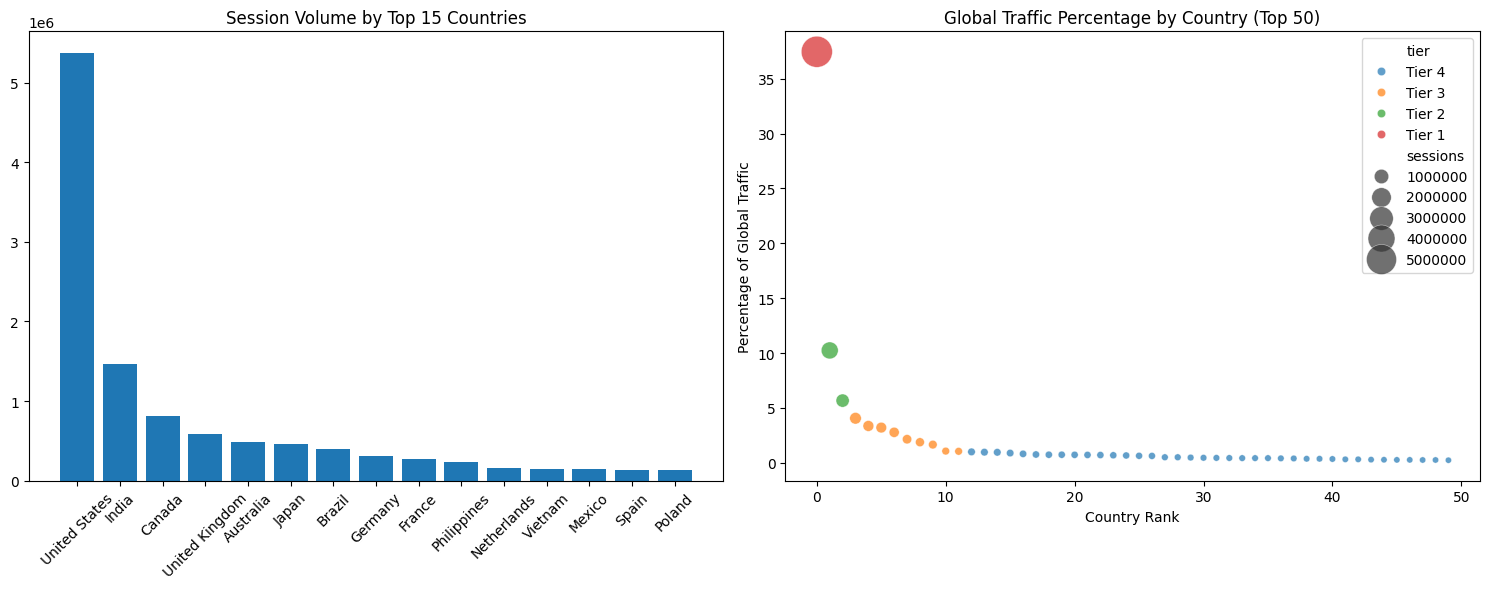

In [255]:
# Step 1: Analyze country traffic baseline
country_traffic = analyze_country_baselines(final_df)

In [256]:
# Step 2: Prepare data by tier
df_with_tier, tier_data = prepare_tier_data(final_df, country_traffic)

In [257]:
# Step 3: Apply ensemble anomaly detection
all_anomaly_results = ensemble_anomaly_detection(tier_data)


Performing ensemble anomaly detection for Tier 3...
Running Isolation Forest...
Running Local Outlier Factor...
Running One-Class SVM...
Running DBSCAN...
Results for Tier 3:
Total periods: 72
IF anomalies: 8 (11.11%)
LOF anomalies: 8 (11.11%)
OCSVM anomalies: 8 (11.11%)
DBSCAN anomalies: 30 (41.67%)
Ensemble anomalies: 12 (16.67%)

Performing ensemble anomaly detection for Tier 4...
Running Isolation Forest...
Running Local Outlier Factor...
Running One-Class SVM...
Running DBSCAN...
Results for Tier 4:
Total periods: 2064
IF anomalies: 310 (15.02%)
LOF anomalies: 307 (14.87%)
OCSVM anomalies: 313 (15.16%)
DBSCAN anomalies: 55 (2.66%)
Ensemble anomalies: 265 (12.84%)

Performing ensemble anomaly detection for Tier 1...
Running Isolation Forest...
Running Local Outlier Factor...
Running One-Class SVM...
Running DBSCAN...
Results for Tier 1:
Total periods: 8
IF anomalies: 1 (12.50%)
LOF anomalies: 1 (12.50%)
OCSVM anomalies: 3 (37.50%)
DBSCAN anomalies: 8 (100.00%)
Ensemble anomalies: 

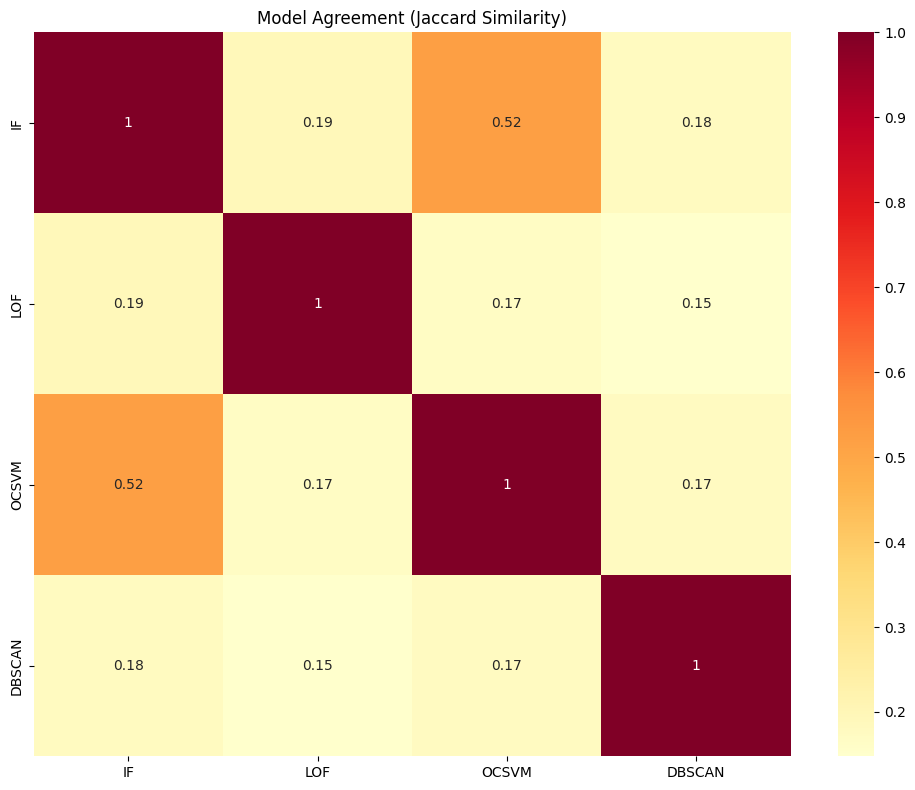


Partial Agreement Cases (Some Models Disagree):
Total cases: 609


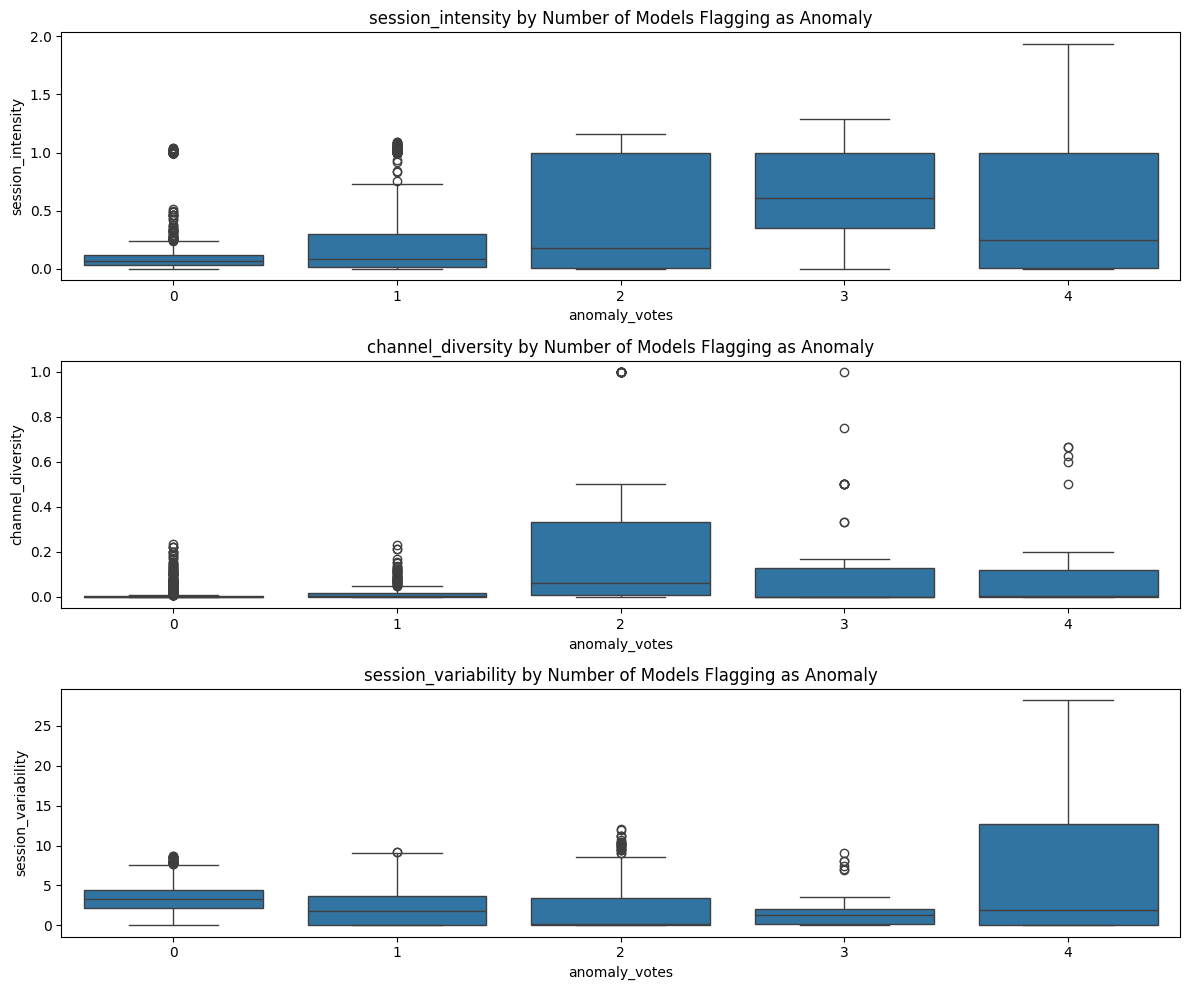

In [258]:
# Step 4: Analyze model agreement
agreement_matrix, disagreement = analyze_model_agreement(all_anomaly_results)

In [259]:
# Step 5: Generate rules
rules, suspicious_patterns = generate_ensemble_rules(all_anomaly_results, df_with_tier)


Columns in anomaly results:
['country', 'year_month', 'sessions_sum', 'sessions_mean', 'sessions_std', 'sessions_count', 'last_touch_channel_nunique', 'device_category_nunique', 'session_intensity', 'channel_diversity', 'session_variability', 'if_anomaly', 'lof_anomaly', 'ocsvm_anomaly', 'dbscan_anomaly', 'ensemble_anomaly', 'anomaly_votes', 'anomaly_score']

Strong Anomalies (3+ models agree):
Total strong anomalies: 95

Columns in original data:
['date', 'year_month', 'sessions', 'last_touch_channel', 'country', 'city', 'visitor_type', 'device_category', 'device_operating_system', 'device_browser', 'device_browser_version', 'device_screen_resolution', 'country_tier']

Joining on columns: ['country', 'year_month']

Top Filtering Rules Generated:
Rule 1: country = 'United States' AND last_touch_channel = 'Direct' AND device_category = 'desktop'
  - Sessions: 244,242
  - Anomaly Score: 0.5961
Rule 2: country = 'United States' AND last_touch_channel = 'Direct' AND device_category = 'mob


Filtering Impact by Country Tier:
              sessions  is_filtered  filtered_sessions  filtered_percentage
country_tier                                                               
Tier 1         5376116         True            4988924                92.80
Tier 2         2283324         True            1611915                70.60
Tier 3         3049005         True            1152634                37.80
Tier 4         3645319         True             297495                 8.16

Overall Filtering Impact:
Total sessions: 14,353,764
Filtered sessions: 8,050,968 (56.09%)


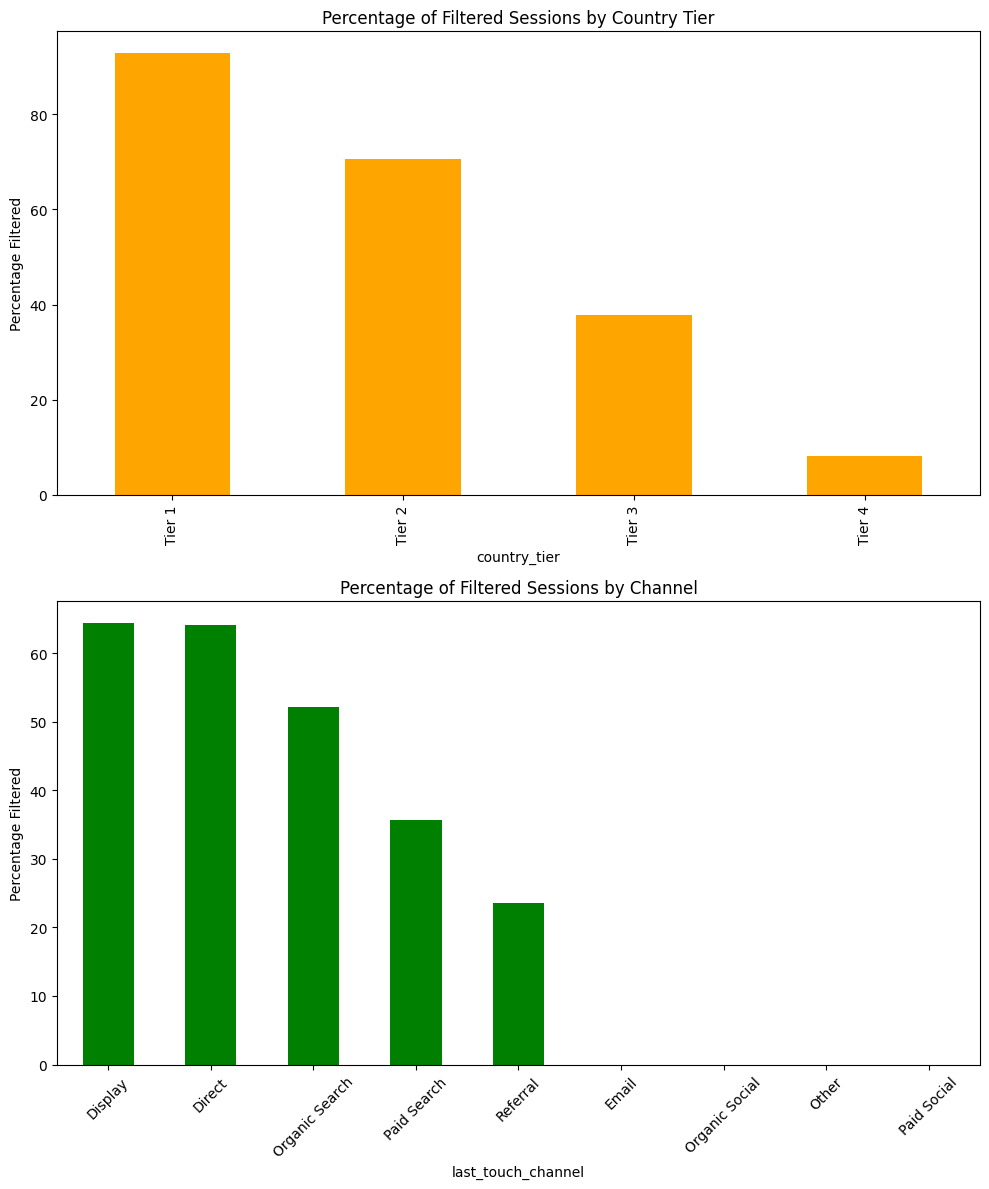


Ensemble Bot Detection Complete!


SyntaxError: 'return' outside function (2000867479.py, line 5)

In [260]:
# Step 6: Evaluate impact
filtered_data, tier_impact = evaluate_filtering_impact(rules, df_with_tier)

print("\nEnsemble Bot Detection Complete!")
return {
    'country_traffic': country_traffic,
    'anomaly_results': all_anomaly_results,
    'agreement_matrix': agreement_matrix,
    'rules': rules,
    'filtered_data': filtered_data,
    'tier_impact': tier_impact
})

# New contextual approach

In [288]:
# BLOCK 1: DATA PREPARATION WITH TIME SEGMENTATION
def prepare_data_with_time(df, start_date=None, end_date=None):
    """
    Prepare the data for bot detection analysis with time range filtering
    
    Parameters:
    df (DataFrame): Input data
    start_date (str): Start date in YYYY-MM-DD format
    end_date (str): End date in YYYY-MM-DD format
    
    Returns:
    DataFrame: Prepared data with time filtering
    """
    print("Preparing data for analysis with time segmentation...")
    # Create a copy for analysis
    df_analysis = df.copy()
    
    # Initialize bot flag and confidence columns
    df_analysis['is_bot'] = False
    df_analysis['bot_confidence'] = 0.0
    df_analysis['bot_rule_matched'] = None
    df_analysis['signal_count'] = 0
    
    # Convert date to datetime if needed
    if 'date' in df_analysis.columns and not pd.api.types.is_datetime64_any_dtype(df_analysis['date']):
        df_analysis['date'] = pd.to_datetime(df_analysis['date'])
    
    # Add month column for monthly aggregation/validation
    if 'date' in df_analysis.columns:
        df_analysis['month'] = df_analysis['date'].dt.to_period('M').astype(str)
    elif 'year_month' in df_analysis.columns:
        df_analysis['month'] = df_analysis['year_month']
    
    # Filter by date range if specified
    if start_date and 'date' in df_analysis.columns:
        start_date = pd.to_datetime(start_date)
        df_analysis = df_analysis[df_analysis['date'] >= start_date]
        print(f"Filtered data to start from {start_date}")
        
    if end_date and 'date' in df_analysis.columns:
        end_date = pd.to_datetime(end_date)
        df_analysis = df_analysis[df_analysis['date'] <= end_date]
        print(f"Filtered data to end at {end_date}")
    
    print(f"Prepared dataset with {len(df_analysis)} rows spanning {df_analysis['month'].nunique()} months")
    
    return df_analysis

In [289]:
# BLOCK 2: TECHNICAL INDICATORS DETECTION WITH SIGNAL COUNTING
def detect_technical_indicators(df_analysis):
    """
    Detect bots based on technical indicators with signal counting
    """
    print("Applying technical indicator rules...")
    
    # Rule 1.1: Missing essential browser data
    if 'device_operating_system' in df_analysis.columns:
        mask = df_analysis['device_operating_system'].isna() & (df_analysis['sessions'] > 1)
        df_analysis.loc[mask, 'is_bot'] = True
        df_analysis.loc[mask, 'bot_confidence'] = 0.95
        df_analysis.loc[mask, 'signal_count'] += 1
        df_analysis.loc[mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = 'Missing OS'
    
    # Rule 1.2: Missing screen resolution (strong bot indicator)
    if 'device_screen_resolution' in df_analysis.columns:
        mask = df_analysis['device_screen_resolution'].isna() & (df_analysis['sessions'] > 1)
        df_analysis.loc[mask, 'is_bot'] = True
        df_analysis.loc[mask, 'bot_confidence'] = 0.95
        df_analysis.loc[mask, 'signal_count'] += 1
        df_analysis.loc[mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = 'Missing resolution'
    
    # Rule 1.3: Bot-specific browser/user agent strings
    if 'device_browser' in df_analysis.columns:
        bot_patterns = [
            'headless', 'phantomjs', 'selenium', 'webdriver', 'crawler', 
            'bot', 'spider', 'http', 'java', 'python', 'curl', 'wget', 'phantom'
        ]
        
        for pattern in bot_patterns:
            mask = df_analysis['device_browser'].str.contains(pattern, case=False, na=False)
            df_analysis.loc[mask, 'is_bot'] = True
            df_analysis.loc[mask, 'bot_confidence'] = 0.95
            df_analysis.loc[mask, 'signal_count'] += 1
            df_analysis.loc[mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = f'Bot UA: {pattern}'
    
    # Rule 1.4: Impossible browser/OS combinations
    if all(col in df_analysis.columns for col in ['device_browser', 'device_operating_system']):
        # Safari on Windows
        mask = (df_analysis['device_browser'].str.contains('Safari', na=False)) & \
               (df_analysis['device_operating_system'].str.contains('Windows', na=False)) & \
               (~df_analysis['device_browser'].str.contains('Chrome', na=False))
        df_analysis.loc[mask, 'is_bot'] = True
        df_analysis.loc[mask, 'bot_confidence'] = 0.9
        df_analysis.loc[mask, 'signal_count'] += 1
        df_analysis.loc[mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = 'Safari on Windows'
        
        # IE on Mac
        mask = (df_analysis['device_browser'].str.contains('Internet Explorer|MSIE|Trident', na=False)) & \
               (df_analysis['device_operating_system'].str.contains('Mac|iOS', na=False))
        df_analysis.loc[mask, 'is_bot'] = True
        df_analysis.loc[mask, 'bot_confidence'] = 0.95
        df_analysis.loc[mask, 'signal_count'] += 1
        df_analysis.loc[mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = 'IE on Mac'
    
    tech_bot_count = df_analysis[df_analysis['is_bot']]['sessions'].sum()
    print(f"Technical rules identified {tech_bot_count:,} bot sessions")
    
    return df_analysis, tech_bot_count

In [290]:
# BLOCK 3: TIME-SERIES ANOMALY DETECTION WITH MONTHLY BREAKDOWN
def detect_time_series_anomalies(df_analysis, tech_bot_count, spike_threshold=5.0):
    """
    Detect bots based on time-series pattern analysis with monthly breakdown
    
    Parameters:
    df_analysis (DataFrame): Analysis dataframe
    tech_bot_count (int): Count of bots already identified by technical rules
    spike_threshold (float): Threshold for traffic spikes (default 5.0)
    
    Returns:
    DataFrame, int: Updated dataframe and count of newly identified bot sessions
    """
    print(f"Performing time-series analysis with spike threshold {spike_threshold}x...")
    
    # Create a record of spikes by month for validation
    spike_records = []
    
    if 'date' in df_analysis.columns:
        # Calculate moving averages and detect spikes
        location_groups = df_analysis.groupby(['country', 'city', 'month']) if 'city' in df_analysis.columns else df_analysis.groupby(['country', 'month'])
        
        for location, location_data in location_groups:
            # Skip if too little data
            if len(location_data) < 10:
                continue
                
            daily_traffic = location_data.groupby('date')['sessions'].sum().reset_index()
            daily_traffic = daily_traffic.sort_values('date')
            
            # Skip locations with infrequent data
            if len(daily_traffic) < 10:
                continue
                
            # Calculate moving averages
            daily_traffic['MA7'] = daily_traffic['sessions'].rolling(window=7).mean()
            daily_traffic['MA14'] = daily_traffic['sessions'].rolling(window=14).mean()
            daily_traffic['MA28'] = daily_traffic['sessions'].rolling(window=28).mean()
            
            # Skip if not enough data for moving averages
            if daily_traffic['MA14'].isna().all():
                continue
                
            # Calculate spike ratio against best available MA
            daily_traffic['spike_ratio'] = daily_traffic['sessions'] / daily_traffic['MA14'].fillna(daily_traffic['MA7'])
            
            # Identify major spikes above threshold
            spike_days = daily_traffic[daily_traffic['spike_ratio'] >= spike_threshold]
            
            # Record monthly spike metrics
            if isinstance(location, tuple) and len(location) > 2:
                country, city, month = location
                monthly_spike_data = {
                    'month': month,
                    'country': country, 
                    'city': city,
                    'spike_count': len(spike_days),
                    'avg_spike_ratio': spike_days['spike_ratio'].mean() if len(spike_days) > 0 else 0,
                    'max_spike_ratio': spike_days['spike_ratio'].max() if len(spike_days) > 0 else 0,
                    'spike_days': spike_days['date'].dt.strftime('%Y-%m-%d').tolist() if len(spike_days) > 0 else []
                }
            else:
                if isinstance(location, tuple):
                    country, month = location
                else:
                    country, month = location[0], None
                
                monthly_spike_data = {
                    'month': month,
                    'country': country,
                    'city': None,
                    'spike_count': len(spike_days),
                    'avg_spike_ratio': spike_days['spike_ratio'].mean() if len(spike_days) > 0 else 0,
                    'max_spike_ratio': spike_days['spike_ratio'].max() if len(spike_days) > 0 else 0,
                    'spike_days': spike_days['date'].dt.strftime('%Y-%m-%d').tolist() if len(spike_days) > 0 else []
                }
            
            if len(spike_days) > 0:
                spike_records.append(monthly_spike_data)
            
            # Mark rows from spike days as suspicious
            for _, spike in spike_days.iterrows():
                location_mask = (df_analysis['date'] == spike['date'])
                if isinstance(location, tuple):
                    if len(location) > 2:  # Country, city, month
                        location_mask = location_mask & (df_analysis['country'] == location[0]) 
                        if location[1] is not None:
                            location_mask = location_mask & (df_analysis['city'] == location[1])
                    else:  # Country, month
                        location_mask = location_mask & (df_analysis['country'] == location[0])
                else:
                    location_mask = location_mask & (df_analysis['country'] == location)
                
                # Calculate confidence based on spike size
                spike_confidence = min(0.5 + (spike['spike_ratio'] / 10), 0.9)
                
                # Increment signal count for this row
                df_analysis.loc[location_mask, 'signal_count'] += 1
                
                # Only update non-bot sessions or sessions with lower confidence
                update_mask = location_mask & ((~df_analysis['is_bot']) | (df_analysis['bot_confidence'] < spike_confidence))
                
                df_analysis.loc[update_mask, 'is_bot'] = True
                df_analysis.loc[update_mask, 'bot_confidence'] = spike_confidence
                df_analysis.loc[update_mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = f'Traffic spike {spike["spike_ratio"]:.1f}x'
    
    time_series_bot_count = df_analysis[df_analysis['is_bot']]['sessions'].sum() - tech_bot_count
    print(f"Time-series analysis identified additional {time_series_bot_count:,} bot sessions")
    print(f"Recorded {len(spike_records)} monthly spike patterns")
    
    # Create a DataFrame of spike records for later analysis
    spike_df = pd.DataFrame(spike_records) if spike_records else pd.DataFrame()
    
    return df_analysis, time_series_bot_count, spike_df

In [291]:
# BLOCK 4: BEHAVIORAL PATTERN ANALYSIS BY MONTH
def detect_behavioral_patterns(df_analysis, tech_bot_count, time_series_bot_count):
    """
    Detect bots based on behavioral pattern analysis with monthly breakdown
    """
    print("Analyzing behavioral patterns by month...")
    
    # Group by month for analysis
    monthly_results = []
    
    # Analyze each month separately
    for month, month_data in df_analysis.groupby('month'):
        # Rule 4.1: Unusual traffic concentration from non-major countries
        # Calculate country traffic distribution
        country_volumes = month_data.groupby('country')['sessions'].sum().sort_values(ascending=False)
        total_sessions = month_data['sessions'].sum()
        
        # Identify major vs. non-major markets
        major_markets = ['United States', 'United Kingdom', 'Canada', 'Australia', 
                        'Germany', 'France', 'Japan', 'India', 'Brazil', 'China']
        
        # For non-major markets, check for suspicious channel dominance
        suspicious_countries = []
        for country, sessions in country_volumes.items():
            # Skip major markets
            if country in major_markets:
                continue
            
            # Check if country has significant traffic (>1% of total)
            country_percentage = sessions / total_sessions * 100
            if country_percentage > 1:
                country_data = month_data[month_data['country'] == country]
                
                # Check channel distribution
                channel_volumes = country_data.groupby('last_touch_channel')['sessions'].sum()
                channel_percentage = channel_volumes / sessions * 100
                
                # If a single non-organic channel dominates (>80%)
                for channel, percentage in channel_percentage.items():
                    if percentage > 80 and channel not in ['Organic Search', 'Direct']:
                        suspicious_countries.append((country, channel, percentage, month))
        
        # Apply rules for suspicious country-channel combinations
        for country, channel, percentage, month_val in suspicious_countries:
            mask = (df_analysis['country'] == country) & \
                   (df_analysis['last_touch_channel'] == channel) & \
                   (df_analysis['month'] == month_val)
            
            # Calculate confidence based on channel dominance
            channel_confidence = min(0.5 + (percentage - 80) / 40, 0.9)
            
            # Increment signal count
            df_analysis.loc[mask, 'signal_count'] += 1
            
            # Only update non-bot sessions or sessions with lower confidence
            update_mask = mask & ((~df_analysis['is_bot']) | (df_analysis['bot_confidence'] < channel_confidence))
            
            df_analysis.loc[update_mask, 'is_bot'] = True
            df_analysis.loc[update_mask, 'bot_confidence'] = channel_confidence
            df_analysis.loc[update_mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = f'Suspicious {country}/{channel}'
        
        # Rule 4.2: Device consistency check by month
        # Legitimate users typically have consistent device/OS/browser
        if all(col in month_data.columns for col in ['country', 'device_category', 'device_browser']):
            # Find abnormal device combinations with high volume
            combinations = month_data.groupby(['country', 'device_category', 'device_browser', 'last_touch_channel'])['sessions'].sum().reset_index()
            
            # For each country
            for country in month_data['country'].unique():
                country_combinations = combinations[combinations['country'] == country]
                
                # Skip countries with limited data
                if len(country_combinations) < 5:
                    continue
                    
                # Get normal patterns (top 80% of traffic)
                country_combinations = country_combinations.sort_values('sessions', ascending=False)
                total_country_sessions = country_combinations['sessions'].sum()
                cumulative_sessions = 0
                normal_pattern_threshold = int(len(country_combinations) * 0.8)
                
                normal_patterns = []
                for idx, row in country_combinations.iterrows():
                    normal_patterns.append(idx)
                    cumulative_sessions += row['sessions']
                    if cumulative_sessions / total_country_sessions > 0.8 or len(normal_patterns) >= normal_pattern_threshold:
                        break
                
                # Find unusual combinations with significant volume
                unusual_combinations = country_combinations.loc[~country_combinations.index.isin(normal_patterns)]
                
                # Flag unusual combinations that have high volume
                for _, combo in unusual_combinations.iterrows():
                    if combo['sessions'] > 10000:  # Significant threshold
                        mask = ((df_analysis['country'] == combo['country']) & 
                               (df_analysis['device_category'] == combo['device_category']) & 
                               (df_analysis['device_browser'] == combo['device_browser']) & 
                               (df_analysis['last_touch_channel'] == combo['last_touch_channel']) &
                               (df_analysis['month'] == month))
                        
                        # Increment signal count
                        df_analysis.loc[mask, 'signal_count'] += 1
                        
                        # Only update non-bot sessions or sessions with lower confidence
                        update_mask = mask & ((~df_analysis['is_bot']) | (df_analysis['bot_confidence'] < 0.7))
                        
                        df_analysis.loc[update_mask, 'is_bot'] = True
                        df_analysis.loc[update_mask, 'bot_confidence'] = 0.7
                        df_analysis.loc[update_mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = f'Unusual pattern with high volume ({month})'
        
        # Record monthly results
        monthly_behavioral_results = {
            'month': month,
            'suspicious_country_channels': len(suspicious_countries),
            'countries_analyzed': len(month_data['country'].unique()),
            'sessions_analyzed': total_sessions
        }
        monthly_results.append(monthly_behavioral_results)
    
    behavioral_bot_count = df_analysis[df_analysis['is_bot']]['sessions'].sum() - tech_bot_count - time_series_bot_count
    print(f"Behavioral analysis identified additional {behavioral_bot_count:,} bot sessions across {len(monthly_results)} months")
    
    # Create a DataFrame of monthly behavioral results
    monthly_behavior_df = pd.DataFrame(monthly_results)
    
    return df_analysis, behavioral_bot_count, monthly_behavior_df

In [292]:
# BLOCK 5: MACHINE LEARNING ANOMALY DETECTION BY MONTH
def detect_ml_anomalies(df_analysis, tech_bot_count, time_series_bot_count, behavioral_bot_count):
    """
    Detect bots using machine learning anomaly detection methods with monthly breakdown
    """
    print("Applying machine learning anomaly detection by month...")
    
    monthly_ml_results = []
    ml_bot_count = 0
    
    # Apply ML anomaly detection month by month
    for month, month_data in df_analysis.groupby('month'):
        print(f"\nProcessing ML detection for month: {month}")
        month_ml_anomalies = 0
        
        # Prepare data for anomaly detection
        if all(col in month_data.columns for col in ['country', 'last_touch_channel', 'device_category']):
            # Group data
            agg_data = month_data.groupby(['country', 'last_touch_channel', 'device_category']).agg({
                'sessions': ['sum', 'mean', 'std', 'count'],
                'device_browser': 'nunique' if 'device_browser' in month_data.columns else 'count',
            }).reset_index()
            
            # Flatten column names
            agg_data.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) and col[1] else col[0] 
                              for col in agg_data.columns]
            
            # Engineer features
            agg_data['session_intensity'] = agg_data['sessions_sum'] / agg_data['sessions_count']
            if 'device_browser_nunique' in agg_data.columns:
                agg_data['browser_diversity'] = agg_data['device_browser_nunique'] / agg_data['sessions_count']
            
            # Select features for anomaly detection
            ml_features = ['sessions_sum', 'session_intensity']
            if 'browser_diversity' in agg_data.columns:
                ml_features.append('browser_diversity')
            if 'sessions_std' in agg_data.columns:
                ml_features.append('sessions_std')
                
            # Skip ML if not enough features or data points
            if len(ml_features) < 2 or len(agg_data) < 20:
                print(f"Skipping ML detection for {month} due to insufficient data/features")
                monthly_ml_results.append({
                    'month': month,
                    'anomalies_detected': 0,
                    'data_points': len(agg_data),
                    'status': 'Skipped - insufficient data'
                })
                continue
            
            # Check for missing values
            has_na = agg_data[ml_features].isna().any().any()
            if has_na:
                print(f"Found missing values in {month}. Applying imputation...")
                # Impute missing values
                imputer = SimpleImputer(strategy='mean')
                agg_data[ml_features] = imputer.fit_transform(agg_data[ml_features])
            
            try:
                # Scale features
                scaler = StandardScaler()
                scaled_features = scaler.fit_transform(agg_data[ml_features])
                
                # Apply ensemble of anomaly detection methods
                # 1. Isolation Forest
                print(f"Running Isolation Forest for {month}...")
                iso_forest = IsolationForest(contamination=0.1, random_state=42)
                iso_predictions = iso_forest.fit_predict(scaled_features)
                
                # 2. Local Outlier Factor
                print(f"Running Local Outlier Factor for {month}...")
                lof = LocalOutlierFactor(n_neighbors=min(20, len(scaled_features)-1), contamination=0.1, novelty=False)
                lof_predictions = lof.fit_predict(scaled_features)
                
                # 3. DBSCAN
                print(f"Running DBSCAN for {month}...")
                dbscan = DBSCAN(eps=0.5, min_samples=min(5, len(scaled_features)//10))
                dbscan_clusters = dbscan.fit_predict(scaled_features)
                dbscan_predictions = np.ones_like(iso_predictions)
                dbscan_predictions[dbscan_clusters == -1] = -1
                
                # Combine predictions (majority voting)
                ensemble_votes = np.vstack([
                    iso_predictions == -1,
                    lof_predictions == -1,
                    dbscan_predictions == -1
                ]).sum(axis=0)
                
                # Mark anomalies (at least 2 algorithms agree)
                agg_data['is_anomaly'] = ensemble_votes >= 2
                agg_data['ensemble_votes'] = ensemble_votes
                
                # Apply ML findings back to original data
                anomaly_count = 0
                for idx, row in agg_data[agg_data['is_anomaly']].iterrows():
                    mask = ((df_analysis['country'] == row['country']) & 
                           (df_analysis['last_touch_channel'] == row['last_touch_channel']) & 
                           (df_analysis['device_category'] == row['device_category']) &
                           (df_analysis['month'] == month))
                    
                    # Calculate confidence based on ensemble votes
                    ml_confidence = 0.6 + (ensemble_votes[idx] / 3) * 0.3
                    
                    # Increment signal count
                    df_analysis.loc[mask, 'signal_count'] += 1
                    
                    # Only update non-bot sessions or sessions with lower confidence
                    update_mask = mask & ((~df_analysis['is_bot']) | (df_analysis['bot_confidence'] < ml_confidence))
                    
                    df_analysis.loc[update_mask, 'is_bot'] = True
                    df_analysis.loc[update_mask, 'bot_confidence'] = ml_confidence
                    df_analysis.loc[update_mask & df_analysis['bot_rule_matched'].isna(), 'bot_rule_matched'] = f'ML anomaly ({ensemble_votes[idx]}/3 models) ({month})'
                    
                    anomaly_count += 1
                
                month_ml_anomalies = df_analysis[(df_analysis['is_bot']) & 
                                                (df_analysis['month'] == month) & 
                                                (df_analysis['bot_rule_matched'].str.contains('ML anomaly', na=False))]['sessions'].sum()
                
                print(f"ML analysis for {month} identified {anomaly_count} anomalous patterns with {month_ml_anomalies:,} sessions")
                
                monthly_ml_results.append({
                    'month': month,
                    'anomalies_detected': anomaly_count,
                    'bot_sessions': month_ml_anomalies,
                    'data_points': len(agg_data),
                    'status': 'Success'
                })
                
            except Exception as e:
                print(f"Error in ML anomaly detection for {month}: {str(e)}")
                monthly_ml_results.append({
                    'month': month,
                    'anomalies_detected': 0,
                    'data_points': len(agg_data),
                    'status': f'Error: {str(e)}'
                })
    
    ml_bot_count = df_analysis[df_analysis['is_bot']]['sessions'].sum() - tech_bot_count - time_series_bot_count - behavioral_bot_count
    print(f"ML analysis identified additional {ml_bot_count:,} bot sessions across all months")
    
    # Create a DataFrame of monthly ML results
    monthly_ml_df = pd.DataFrame(monthly_ml_results)
    
    return df_analysis, ml_bot_count, monthly_ml_df

In [305]:
# BLOCK 6: GENERATE MONTHLY FILTERING RULES WITH MULTI-SIGNAL VALIDATION
def generate_filtering_rules_with_signals(df_analysis, signal_threshold=4):
    """
    Generate high-confidence filtering rules based on detected patterns with multi-signal validation
    
    Parameters:
    df_analysis (DataFrame): Analysis dataframe
    signal_threshold (int): Minimum number of signals required for high confidence (default 4)
    
    Returns:
    list: Filter rules with monthly breakdown
    """
    print(f"Generating high-confidence filtering rules (signal threshold: {signal_threshold})...")
    
    # Filter to sessions with sufficient signals for high confidence
    high_signal_sessions = df_analysis[df_analysis['signal_count'] >= signal_threshold]
    high_confidence_bots = high_signal_sessions[high_signal_sessions['is_bot']]
    
    print(f"Found {len(high_confidence_bots):,} sessions with {signal_threshold}+ bot signals")
    
    # Generate rules based on country-channel-device-month combinations
    rule_dimensions = [col for col in ['country', 'last_touch_channel', 'device_category', 'month'] 
                      if col in df_analysis.columns]
    
    if rule_dimensions and len(high_confidence_bots) > 0:
        # Aggregate by dimensions
        rule_patterns = high_confidence_bots.groupby(rule_dimensions).agg({
            'sessions': 'sum',
            'bot_confidence': 'mean',
            'signal_count': 'mean',
            'bot_rule_matched': lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else 'Multiple rules'
        }).reset_index()
        
        # Filter significant patterns
        significant_patterns = rule_patterns[rule_patterns['sessions'] > 1000].sort_values(['month', 'sessions'], ascending=[True, False])
        
        # Generate rules
        filter_rules = []
        for _, pattern in significant_patterns.iterrows():
            rule = {}
            for dim in rule_dimensions:
                rule[dim] = pattern[dim]
            
            rule['sessions'] = int(pattern['sessions'])
            rule['confidence'] = float(pattern['bot_confidence'])
            rule['avg_signals'] = float(pattern['signal_count'])
            rule['matched_rule'] = pattern['bot_rule_matched']
            
            filter_rules.append(rule)
        
        print(f"Generated {len(filter_rules)} high-confidence filtering rules")
        
        # Create a safe summary of rules by month
        if 'month' in significant_patterns.columns:
            # First, ensure we have at least one rule with a month
            if significant_patterns['month'].notna().any():
                try:
                    # Try creating a summary, handling potential column count mismatches
                    month_counts = significant_patterns.groupby('month').size()
                    country_counts = significant_patterns.groupby('month')['country'].nunique()
                    session_sums = significant_patterns.groupby('month')['sessions'].sum()
                    
                    print("\nRules by Month:")
                    for month in sorted(significant_patterns['month'].unique()):
                        if month in month_counts:
                            print(f"- {month}: {month_counts[month]} rules, "
                                  f"{country_counts.get(month, 0)} countries, "
                                  f"{session_sums.get(month, 0):,} sessions")
                except Exception as e:
                    print(f"Note: Could not generate monthly summary: {str(e)}")
        
        return filter_rules
    else:
        print("No high-confidence rules could be generated")
        return []

In [295]:
# BLOCK 7: SUMMARIZE RESULTS WITH MONTHLY BREAKDOWN
def summarize_results_by_month(df_analysis, filter_rules, spike_df=None, behavior_df=None, ml_df=None):
    """
    Generate a summary of bot detection results with monthly breakdown
    """
    print("Summarizing results by month...")
    
    # Overall metrics
    total_sessions = df_analysis['sessions'].sum()
    bot_sessions = df_analysis[df_analysis['is_bot']]['sessions'].sum()
    high_confidence_sessions = df_analysis[(df_analysis['is_bot']) & (df_analysis['bot_confidence'] >= 0.8)]['sessions'].sum()
    multi_signal_sessions = df_analysis[(df_analysis['is_bot']) & (df_analysis['signal_count'] >= 4)]['sessions'].sum()
    
    print("\nOverall Bot Detection Summary:")
    print(f"Total sessions analyzed: {total_sessions:,}")
    print(f"Total bot sessions detected: {bot_sessions:,} ({bot_sessions/total_sessions*100:.2f}%)")
    print(f"High-confidence bot sessions: {high_confidence_sessions:,} ({high_confidence_sessions/total_sessions*100:.2f}%)")
    print(f"Multi-signal bot sessions: {multi_signal_sessions:,} ({multi_signal_sessions/total_sessions*100:.2f}%)")
    
    # Monthly breakdown
    monthly_results = []
    
    for month, month_data in df_analysis.groupby('month'):
        month_total = month_data['sessions'].sum()
        month_bots = month_data[month_data['is_bot']]['sessions'].sum()
        month_high_conf = month_data[(month_data['is_bot']) & (month_data['bot_confidence'] >= 0.8)]['sessions'].sum()
        month_multi_signal = month_data[(month_data['is_bot']) & (month_data['signal_count'] >= 4)]['sessions'].sum()
        
        # Count different detection methods for this month
        detection_methods = month_data[month_data['is_bot']].groupby('bot_rule_matched')['sessions'].sum()
        top_methods = detection_methods.sort_values(ascending=False).head(3)
        
        # Count top bot countries for this month
        bot_countries = month_data[month_data['is_bot']].groupby('country')['sessions'].sum().sort_values(ascending=False).head(3)
        
        # Get rule count for this month
        month_rules = len([r for r in filter_rules if r['month'] == month]) if filter_rules else 0
        
        # Compile monthly summary
        monthly_summary = {
            'month': month,
            'total_sessions': month_total,
            'bot_sessions': month_bots,
            'bot_percentage': (month_bots / month_total * 100) if month_total > 0 else 0,
            'high_conf_sessions': month_high_conf,
            'high_conf_percentage': (month_high_conf / month_total * 100) if month_total > 0 else 0,
            'multi_signal_sessions': month_multi_signal,
            'multi_signal_percentage': (month_multi_signal / month_total * 100) if month_total > 0 else 0,
            'rule_count': month_rules,
            'top_detection_methods': top_methods.to_dict(),
            'top_bot_countries': bot_countries.to_dict()
        }
        
        # Add spike stats if available
        if spike_df is not None and not spike_df.empty:
            month_spikes = spike_df[spike_df['month'] == month]
            if not month_spikes.empty:
                monthly_summary['spike_count'] = month_spikes['spike_count'].sum()
                monthly_summary['max_spike_ratio'] = month_spikes['max_spike_ratio'].max()
            else:
                monthly_summary['spike_count'] = 0
                monthly_summary['max_spike_ratio'] = 0
        
        # Add ML stats if available
        if ml_df is not None and not ml_df.empty:
            month_ml = ml_df[ml_df['month'] == month]
            if not month_ml.empty:
                monthly_summary['ml_anomalies'] = month_ml['anomalies_detected'].sum()
                monthly_summary['ml_status'] = month_ml['status'].iloc[0]
            else:
                monthly_summary['ml_anomalies'] = 0
                monthly_summary['ml_status'] = 'No data'
        
        monthly_results.append(monthly_summary)
    
    # Convert to DataFrame for better visualization
    monthly_summary_df = pd.DataFrame(monthly_results).sort_values('month')
    
    print("\nMonthly Bot Detection Breakdown:")
    print(monthly_summary_df[['month', 'total_sessions', 'bot_sessions', 'bot_percentage', 'multi_signal_percentage', 'rule_count']])
    
    # Detection method breakdown
    rule_type_counts = df_analysis[df_analysis['is_bot']].groupby('bot_rule_matched')['sessions'].sum().sort_values(ascending=False)
    
    print("\nBot Detection by Rule Type:")
    for rule_type, sessions in rule_type_counts.head(10).items():
        print(f"- {rule_type}: {sessions:,} sessions ({sessions/bot_sessions*100:.2f}% of bots)")
    
    # Country distribution
    country_bots = df_analysis[df_analysis['is_bot']].groupby('country')['sessions'].sum().sort_values(ascending=False)
    
    print("\nTop Countries with Bot Traffic:")
    for country, sessions in country_bots.head(10).items():
        country_total = df_analysis[df_analysis['country'] == country]['sessions'].sum()
        print(f"- {country}: {sessions:,} sessions ({sessions/country_total*100:.2f}% of country traffic)")
    
    # Format results into a dictionary
    results = {
        'overall': {
            'total_sessions': total_sessions,
            'bot_sessions': bot_sessions,
            'high_confidence_sessions': high_confidence_sessions,
            'multi_signal_sessions': multi_signal_sessions,
            'bot_percentage': bot_sessions/total_sessions*100 if total_sessions > 0 else 0,
        },
        'monthly': monthly_summary_df.to_dict('records'),
        'rule_effectiveness': rule_type_counts.head(20).to_dict(),
        'country_distribution': country_bots.head(10).to_dict(),
        'filter_rules': filter_rules
    }
    
    return results, monthly_summary_df

In [296]:
# BLOCK 8: MAIN EXECUTION FUNCTION
def detect_bots_by_month(df, start_date=None, end_date=None, spike_threshold=5.0, signal_threshold=4):
    """
    Complete bot detection process with monthly breakdown and multi-signal validation
    
    Parameters:
    df (DataFrame): Input data
    start_date (str): Start date in YYYY-MM-DD format
    end_date (str): End date in YYYY-MM-DD format
    spike_threshold (float): Threshold for traffic spike detection
    signal_threshold (int): Minimum signals required for high confidence
    
    Returns:
    dict: Complete results with monthly breakdown
    """
    print(f"Starting time-based bot detection (spike threshold: {spike_threshold}x, signal threshold: {signal_threshold}+)...")
    
    # Step 1: Prepare data with time segmentation
    df_analysis = prepare_data_with_time(df, start_date, end_date)
    
    # Step 2: Technical indicators
    df_analysis, tech_bot_count = detect_technical_indicators(df_analysis)
    
    # Step 3: Time-series anomalies
    df_analysis, time_series_bot_count, spike_df = detect_time_series_anomalies(
        df_analysis, tech_bot_count, spike_threshold=spike_threshold
    )
    
    # Step 4: Behavioral patterns
    df_analysis, behavioral_bot_count, behavior_df = detect_behavioral_patterns(
        df_analysis, tech_bot_count, time_series_bot_count
    )
    
    # Step 5: ML anomaly detection
    df_analysis, ml_bot_count, ml_df = detect_ml_anomalies(
        df_analysis, tech_bot_count, time_series_bot_count, behavioral_bot_count
    )
    
    # Step 6: Generate filtering rules
    filter_rules = generate_filtering_rules_with_signals(df_analysis, signal_threshold=signal_threshold)
    
    # Step 7: Summarize results
    results, monthly_summary = summarize_results_by_month(
        df_analysis, filter_rules, spike_df, behavior_df, ml_df
    )
    
    # Add detection counts to results
    results['detection_counts'] = {
        'technical': tech_bot_count,
        'time_series': time_series_bot_count,
        'behavioral': behavioral_bot_count,
        'ml': ml_bot_count
    }
    
    return {
        'data': df_analysis,
        'results': results,
        'monthly_summary': monthly_summary,
        'spike_data': spike_df,
        'ml_data': ml_df,
        'behavior_data': behavior_df,
        'filter_rules': filter_rules
    }

In [297]:
# BLOCK 9: VISUALIZATION AND REPORTING
def generate_bot_detection_report(result, output_dir=None):
    """
    Generate visualizations and reports from bot detection results
    
    Parameters:
    result (dict): Results from detect_bots_by_month
    output_dir (str): Directory to save reports (None for display only)
    
    Returns:
    dict: Report metadata
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime
    import os
    
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_dir = os.path.join(output_dir, f"bot_report_{timestamp}")
        os.makedirs(report_dir, exist_ok=True)
        print(f"Generating report in {report_dir}")
    
    # Extract data
    df_analysis = result['data']
    monthly_summary = result['monthly_summary']
    spike_data = result['spike_data']
    filter_rules = result['filter_rules']
    
    # 1. Monthly Bot Percentage Chart
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='month', y='bot_percentage', data=monthly_summary)
    plt.title('Bot Traffic Percentage by Month')
    plt.xlabel('Month')
    plt.ylabel('Bot Percentage (%)')
    plt.xticks(rotation=45)
    plt.axhline(y=monthly_summary['bot_percentage'].mean(), color='r', linestyle='--', label='Average')
    plt.legend()
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(report_dir, 'monthly_bot_percentage.png'))
        plt.close()
    else:
        plt.show()
    
    # 2. Bot Detection Method Breakdown
    detection_methods = df_analysis[df_analysis['is_bot']].groupby('bot_rule_matched')['sessions'].sum()
    top_methods = detection_methods.sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=top_methods.values, y=top_methods.index)
    plt.title('Top 10 Bot Detection Methods')
    plt.xlabel('Sessions')
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(report_dir, 'detection_methods.png'))
        plt.close()
    else:
        plt.show()
    
    # 3. Signal Count Distribution
    signal_counts = df_analysis[df_analysis['is_bot']].groupby('signal_count')['sessions'].sum()
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=signal_counts.index, y=signal_counts.values)
    plt.title('Bot Sessions by Signal Count')
    plt.xlabel('Number of Signals')
    plt.ylabel('Sessions')
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(report_dir, 'signal_distribution.png'))
        plt.close()
    else:
        plt.show()
    
    # 4. Monthly Multi-Signal vs Regular Bot Detection
    plt.figure(figsize=(12, 6))
    monthly_summary['regular_bot_percentage'] = monthly_summary['bot_percentage'] - monthly_summary['multi_signal_percentage']
    
    # Stacked bar chart
    ax = monthly_summary.plot.bar(x='month', 
                                 y=['multi_signal_percentage', 'regular_bot_percentage'],
                                 stacked=True,
                                 figsize=(12, 6),
                                 color=['darkblue', 'skyblue'])
    
    plt.title('Bot Traffic by Confidence Level')
    plt.xlabel('Month')
    plt.ylabel('Percentage (%)')
    plt.legend(['High Confidence (4+ signals)', 'Lower Confidence (<4 signals)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(report_dir, 'monthly_confidence_levels.png'))
        plt.close()
    else:
        plt.show()
    
    # 5. Traffic Spike Analysis (if spike data available)
    if not spike_data.empty:
        spike_counts = spike_data.groupby('month')['spike_count'].sum()
        spike_avg = spike_data.groupby('month')['avg_spike_ratio'].mean()
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        color = 'tab:blue'
        ax1.set_xlabel('Month')
        ax1.set_ylabel('Spike Count', color=color)
        ax1.bar(spike_counts.index, spike_counts.values, color=color, alpha=0.7)
        ax1.tick_params(axis='y', labelcolor=color)
        
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Average Spike Ratio', color=color)
        ax2.plot(spike_avg.index, spike_avg.values, color=color, marker='o')
        ax2.tick_params(axis='y', labelcolor=color)
        
        plt.title('Traffic Spike Analysis by Month')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        if output_dir:
            plt.savefig(os.path.join(report_dir, 'traffic_spikes.png'))
            plt.close()
        else:
            plt.show()
    
    # 6. Generate HTML Report with Tables
    if output_dir:
        html_report = f"""
        <html>
        <head>
            <title>Bot Detection Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; }}
                h1, h2, h3 {{ color: #2c3e50; }}
                table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                tr:nth-child(even) {{ background-color: #f9f9f9; }}
                .summary {{ background-color: #e8f4f8; padding: 15px; border-radius: 5px; margin-bottom: 20px; }}
                .highlight {{ font-weight: bold; color: #c0392b; }}
            </style>
        </head>
        <body>
            <h1>Bot Traffic Analysis Report</h1>
            <div class="summary">
                <h2>Overall Summary</h2>
                <p>Total Sessions: {result['results']['overall']['total_sessions']:,}</p>
                <p>Bot Sessions: {result['results']['overall']['bot_sessions']:,} ({result['results']['overall']['bot_percentage']:.2f}%)</p>
                <p>High Confidence Bot Sessions (4+ signals): {result['results']['overall']['multi_signal_sessions']:,} ({result['results']['overall']['multi_signal_sessions']/result['results']['overall']['bot_sessions']*100 if result['results']['overall']['bot_sessions'] > 0 else 0:.2f}% of bot traffic)</p>
            </div>
            
            <h2>Monthly Bot Traffic Analysis</h2>
            <table>
                <tr>
                    <th>Month</th>
                    <th>Total Sessions</th>
                    <th>Bot Sessions</th>
                    <th>Bot %</th>
                    <th>High Confidence %</th>
                    <th>Rules Generated</th>
                </tr>
        """
        
        # Add monthly data rows
        for _, row in monthly_summary.sort_values('month').iterrows():
            html_report += f"""
                <tr>
                    <td>{row['month']}</td>
                    <td>{row['total_sessions']:,}</td>
                    <td>{row['bot_sessions']:,}</td>
                    <td>{row['bot_percentage']:.2f}%</td>
                    <td>{row['multi_signal_percentage']:.2f}%</td>
                    <td>{row['rule_count']}</td>
                </tr>
            """
        
        html_report += """
            </table>
            
            <h2>Top Bot Detection Rules by Month</h2>
            <table>
                <tr>
                    <th>Month</th>
                    <th>Country</th>
                    <th>Channel</th>
                    <th>Device</th>
                    <th>Sessions</th>
                    <th>Confidence</th>
                    <th>Avg Signals</th>
                    <th>Detection Type</th>
                </tr>
        """
        
        # Add filter rules
        for rule in filter_rules:
            html_report += f"""
                <tr>
                    <td>{rule['month']}</td>
                    <td>{rule['country']}</td>
                    <td>{rule['last_touch_channel']}</td>
                    <td>{rule['device_category']}</td>
                    <td>{rule['sessions']:,}</td>
                    <td>{rule['confidence']*100:.2f}%</td>
                    <td>{rule['avg_signals']:.1f}</td>
                    <td>{rule['matched_rule']}</td>
                </tr>
            """
        
        html_report += """
            </table>
            
            <h2>Top Bot Traffic Countries</h2>
            <table>
                <tr>
                    <th>Country</th>
                    <th>Bot Sessions</th>
                    <th>% of Country Traffic</th>
                </tr>
        """
        
        # Add country data
        for country, sessions in result['results']['country_distribution'].items():
            country_total = df_analysis[df_analysis['country'] == country]['sessions'].sum()
            percentage = sessions/country_total*100 if country_total > 0 else 0
            html_report += f"""
                <tr>
                    <td>{country}</td>
                    <td>{sessions:,}</td>
                    <td>{percentage:.2f}%</td>
                </tr>
            """
        
        html_report += """
            </table>
            
            <div>
                <h2>Detection Methods Breakdown</h2>
                <table>
                    <tr>
                        <th>Detection Method</th>
                        <th>Sessions</th>
                        <th>% of Bot Traffic</th>
                    </tr>
        """
        
        # Add detection methods
        for method, sessions in result['results']['rule_effectiveness'].items():
            percentage = sessions/result['results']['overall']['bot_sessions']*100 if result['results']['overall']['bot_sessions'] > 0 else 0
            html_report += f"""
                <tr>
                    <td>{method}</td>
                    <td>{sessions:,}</td>
                    <td>{percentage:.2f}%</td>
                </tr>
            """
        
        html_report += """
            </table>
            </div>
            
            <div>
                <h2>Images</h2>
                <img src="monthly_bot_percentage.png" style="max-width: 100%; margin-bottom: 20px;">
                <img src="detection_methods.png" style="max-width: 100%; margin-bottom: 20px;">
                <img src="signal_distribution.png" style="max-width: 100%; margin-bottom: 20px;">
                <img src="monthly_confidence_levels.png" style="max-width: 100%; margin-bottom: 20px;">
        """
        
        if not spike_data.empty:
            html_report += """
                <img src="traffic_spikes.png" style="max-width: 100%; margin-bottom: 20px;">
            """
        
        html_report += """
            </div>
        </body>
        </html>
        """
        
        # Write HTML report
        with open(os.path.join(report_dir, 'bot_report.html'), 'w') as f:
            f.write(html_report)
        
        # Write CSV exports
        monthly_summary.to_csv(os.path.join(report_dir, 'monthly_summary.csv'), index=False)
        
        if not spike_data.empty:
            spike_data.to_csv(os.path.join(report_dir, 'traffic_spikes.csv'), index=False)
        
        # Export filter rules
        pd.DataFrame(filter_rules).to_csv(os.path.join(report_dir, 'filter_rules.csv'), index=False)
        
        print(f"Report generated successfully at {report_dir}")
        return {'report_dir': report_dir, 'timestamp': timestamp}
    
    return {'visualizations_displayed': True}

In [300]:
# BLOCK 10: IMPLEMENTATION WITH DATAFRAME INPUT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

def run_bot_detection(df, start_date=None, end_date=None, spike_threshold=5.0, 
                     signal_threshold=4, skip_ml=False, output_dir=None):
    """
    Run the bot detection process on a pandas DataFrame
    
    Parameters:
    df (DataFrame): Input dataframe with web analytics data
    start_date (str): Optional start date for analysis (YYYY-MM-DD)
    end_date (str): Optional end date for analysis (YYYY-MM-DD)
    spike_threshold (float): Traffic spike threshold multiplier (default 5.0)
    signal_threshold (int): Signals required for high confidence (default 4)
    skip_ml (bool): Whether to skip ML anomaly detection (default False)
    output_dir (str): Optional directory path to save reports
    
    Returns:
    dict: Complete results from bot detection
    """
    print(f"Starting bot detection analysis on DataFrame with {len(df):,} rows...")
    start_time = datetime.now()
    
    # Validate input dataframe
    required_columns = ['country', 'sessions']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in DataFrame")
    
    # Check if we have date column
    if 'date' not in df.columns and 'year_month' not in df.columns:
        print("Warning: Neither 'date' nor 'year_month' column found. Results won't be time-segmented.")
    
    # Run appropriate detection function
    if skip_ml:
        print("Running without ML anomaly detection...")
        result = run_without_ml(df, start_date, end_date, spike_threshold, signal_threshold)
    else:
        print("Running complete detection with ML anomaly detection...")
        result = detect_bots_by_month(
            df,
            start_date=start_date,
            end_date=end_date,
            spike_threshold=spike_threshold,
            signal_threshold=signal_threshold
        )
    
    # Calculate execution time
    end_time = datetime.now()
    execution_time = end_time - start_time
    print(f"\nBot detection completed in {execution_time}")
    
    # Display summary
    total = result['results']['overall']['total_sessions']
    bots = result['results']['overall']['bot_sessions']
    high_conf = result['results']['overall']['multi_signal_sessions']
    
    print(f"\nBot detection summary:")
    print(f"- Total sessions: {total:,}")
    print(f"- Bot sessions: {bots:,} ({bots/total*100:.2f}%)")
    print(f"- High confidence (4+ signals): {high_conf:,} ({high_conf/total*100:.2f}%)")
    print(f"- Monthly breakdown: {result['monthly_summary']['month'].nunique()} months analyzed")
    print(f"- Filter rules generated: {len(result['filter_rules'])}")
    
    # Generate report if output directory provided
    if output_dir:
        report_info = generate_bot_detection_report(result, output_dir)
        print(f"Report generated at {report_info.get('report_dir', output_dir)}")
    
    return result

def run_without_ml(df, start_date=None, end_date=None, spike_threshold=5.0, signal_threshold=4):
    """
    Run bot detection without the ML component
    """
    # Step 1: Prepare data with time segmentation
    df_analysis = prepare_data_with_time(df, start_date, end_date)
    
    # Step 2: Technical indicators
    df_analysis, tech_bot_count = detect_technical_indicators(df_analysis)
    
    # Step 3: Time-series anomalies
    df_analysis, time_series_bot_count, spike_df = detect_time_series_anomalies(
        df_analysis, tech_bot_count, spike_threshold=spike_threshold
    )
    
    # Step 4: Behavioral patterns
    df_analysis, behavioral_bot_count, behavior_df = detect_behavioral_patterns(
        df_analysis, tech_bot_count, time_series_bot_count
    )
    
    # Step 5: Generate filtering rules
    filter_rules = generate_filtering_rules_with_signals(
        df_analysis, signal_threshold=signal_threshold
    )
    
    # Step 6: Summarize results
    results, monthly_summary = summarize_results_by_month(
        df_analysis, filter_rules, spike_df, behavior_df
    )
    
    # Add detection counts to results
    results['detection_counts'] = {
        'technical': tech_bot_count,
        'time_series': time_series_bot_count,
        'behavioral': behavioral_bot_count,
        'ml': 0
    }
    
    return {
        'data': df_analysis,
        'results': results,
        'monthly_summary': monthly_summary,
        'spike_data': spike_df,
        'behavior_data': behavior_df,
        'filter_rules': filter_rules,
        'ml_data': pd.DataFrame()  # Empty DataFrame since ML was skipped
    }

def get_top_bot_rules(result, min_confidence=0.8, min_sessions=10000, top_n=20):
    """
    Extract top bot detection rules from the result
    
    Parameters:
    result (dict): Result from bot detection
    min_confidence (float): Minimum confidence level (0-1)
    min_sessions (int): Minimum number of sessions
    top_n (int): Maximum number of rules to return
    
    Returns:
    DataFrame: Top bot rules
    """
    filter_rules = result['filter_rules']
    
    if not filter_rules:
        print("No filter rules found in the result")
        return pd.DataFrame()
    
    # Convert to DataFrame if it's a list
    if isinstance(filter_rules, list):
        rules_df = pd.DataFrame(filter_rules)
    else:
        rules_df = filter_rules
    
    # Filter by confidence and sessions
    filtered_rules = rules_df[
        (rules_df['confidence'] >= min_confidence) & 
        (rules_df['sessions'] >= min_sessions)
    ]
    
    # Sort by sessions and get top_n
    top_rules = filtered_rules.sort_values('sessions', ascending=False).head(top_n)
    
    return top_rules

def apply_bot_rules(df, rules, apply_threshold=0.8):
    """
    Apply bot detection rules to a new DataFrame
    
    Parameters:
    df (DataFrame): Target DataFrame
    rules (DataFrame): Rules DataFrame from get_top_bot_rules
    apply_threshold (float): Confidence threshold for applying rules
    
    Returns:
    DataFrame: DataFrame with bot flags applied
    """
    # Create a copy of the DataFrame
    df_result = df.copy()
    
    # Add bot flag columns if they don't exist
    if 'is_bot' not in df_result.columns:
        df_result['is_bot'] = False
    
    if 'bot_rule_matched' not in df_result.columns:
        df_result['bot_rule_matched'] = None
    
    if 'bot_confidence' not in df_result.columns:
        df_result['bot_confidence'] = 0.0
    
    # Convert date to datetime and add month column if needed
    if 'date' in df_result.columns and not pd.api.types.is_datetime64_any_dtype(df_result['date']):
        df_result['date'] = pd.to_datetime(df_result['date'])
        
    if 'date' in df_result.columns and 'month' not in df_result.columns:
        df_result['month'] = df_result['date'].dt.to_period('M').astype(str)
    elif 'year_month' in df_result.columns and 'month' not in df_result.columns:
        df_result['month'] = df_result['year_month']
    
    # Apply each rule
    rules_applied = 0
    sessions_flagged = 0
    
    for _, rule in rules.iterrows():
        if rule['confidence'] < apply_threshold:
            continue
            
        # Create mask based on rule dimensions
        mask = pd.Series(True, index=df_result.index)
        
        # Apply each dimension
        if 'country' in rule and 'country' in df_result.columns:
            mask &= df_result['country'] == rule['country']
            
        if 'last_touch_channel' in rule and 'last_touch_channel' in df_result.columns:
            mask &= df_result['last_touch_channel'] == rule['last_touch_channel']
            
        if 'device_category' in rule and 'device_category' in df_result.columns:
            mask &= df_result['device_category'] == rule['device_category']
            
        if 'month' in rule and 'month' in df_result.columns:
            mask &= df_result['month'] == rule['month']
        
        # Apply the rule if matched
        matched_rows = mask.sum()
        if matched_rows > 0:
            # Only update if confidence is higher than existing
            update_mask = mask & ((~df_result['is_bot']) | (df_result['bot_confidence'] < rule['confidence']))
            
            df_result.loc[update_mask, 'is_bot'] = True
            df_result.loc[update_mask, 'bot_confidence'] = rule['confidence']
            df_result.loc[update_mask, 'bot_rule_matched'] = rule.get('matched_rule', 'Applied rule')
            
            # Count the sessions flagged
            if 'sessions' in df_result.columns:
                sessions_affected = df_result.loc[update_mask, 'sessions'].sum()
            else:
                sessions_affected = update_mask.sum()
                
            rules_applied += 1
            sessions_flagged += sessions_affected
            
            print(f"Applied rule: {rule.get('matched_rule', 'Rule')}, Rows affected: {update_mask.sum():,}, Sessions: {sessions_affected:,}")
    
    print(f"\nApplied {rules_applied} rules, flagged {sessions_flagged:,} sessions as bots")
    return df_result

In [307]:
# BLOCK 12: TRAFFIC SPIKE GATEKEEPER
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

def detect_traffic_spikes(df, window_size=14, spike_threshold=5.0, min_sessions=100):
    """
    Detect traffic spikes without running the full bot detection
    
    Parameters:
    df (DataFrame): Input data with date and sessions columns
    window_size (int): Window size for moving average
    spike_threshold (float): Multiple of normal traffic to consider a spike
    min_sessions (int): Minimum sessions to consider for analysis
    
    Returns:
    DataFrame: Spike data with flags
    """
    print(f"Detecting traffic spikes (threshold: {spike_threshold}x)...")
    
    # Ensure date column is datetime
    if 'date' not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column")
    
    df_copy = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_copy['date']):
        df_copy['date'] = pd.to_datetime(df_copy['date'])
    
    # Add month column
    df_copy['month'] = df_copy['date'].dt.to_period('M').astype(str)
    
    # Initialize spike columns
    df_copy['is_spike_day'] = False
    df_copy['spike_ratio'] = 0.0
    
    # Group data for analysis
    if 'country' in df_copy.columns:
        groups = df_copy.groupby(['country', 'month'])
    else:
        groups = df_copy.groupby('month')
    
    spike_records = []
    
    for group_key, group_data in groups:
        # Skip groups with insufficient data
        if len(group_data) < window_size or group_data['sessions'].sum() < min_sessions:
            continue
        
        # Aggregate by date if not already date-level
        if len(group_data) > len(group_data['date'].unique()):
            daily_data = group_data.groupby('date')['sessions'].sum().reset_index()
        else:
            daily_data = group_data[['date', 'sessions']].copy()
        
        # Sort by date
        daily_data = daily_data.sort_values('date')
        
        # Calculate moving average
        daily_data['MA'] = daily_data['sessions'].rolling(window=window_size, min_periods=window_size//2).mean()
        
        # Calculate spike ratio
        daily_data['spike_ratio'] = daily_data['sessions'] / daily_data['MA'].fillna(daily_data['sessions'].mean())
        
        # Identify spikes
        daily_data['is_spike'] = daily_data['spike_ratio'] >= spike_threshold
        
        # Record spike days
        spike_days = daily_data[daily_data['is_spike']]
        
        for _, spike in spike_days.iterrows():
            # Create record of this spike
            if isinstance(group_key, tuple):
                country, month = group_key
                spike_record = {
                    'date': spike['date'],
                    'month': month,
                    'country': country,
                    'sessions': spike['sessions'],
                    'normal_traffic': spike['MA'],
                    'spike_ratio': spike['spike_ratio'],
                    'is_spike': True
                }
            else:
                spike_record = {
                    'date': spike['date'],
                    'month': group_key,  # month is the group key
                    'sessions': spike['sessions'],
                    'normal_traffic': spike['MA'],
                    'spike_ratio': spike['spike_ratio'],
                    'is_spike': True
                }
            
            spike_records.append(spike_record)
            
            # Mark this date as a spike in the original dataframe
            spike_mask = df_copy['date'] == spike['date']
            if isinstance(group_key, tuple):
                spike_mask &= df_copy['country'] == group_key[0]
            
            df_copy.loc[spike_mask, 'is_spike_day'] = True
            df_copy.loc[spike_mask, 'spike_ratio'] = spike['spike_ratio']
    
    # Create a DataFrame of all spikes
    spike_df = pd.DataFrame(spike_records) if spike_records else pd.DataFrame()
    
    if len(spike_df) > 0:
        print(f"Detected {len(spike_df)} traffic spikes across {spike_df['month'].nunique()} months")
        
        # Show spikes by month
        spike_by_month = spike_df.groupby('month').size().reset_index(name='spike_count')
        print("\nSpikes by month:")
        for _, row in spike_by_month.iterrows():
            print(f"- {row['month']}: {row['spike_count']} spikes")
    else:
        print("No traffic spikes detected")
    
    return spike_df, df_copy

def filter_and_validate_spikes(spike_df, min_spike_ratio=8.0, min_country_occurrences=2):
    """
    Filter spikes to find most reliable bot indicators
    
    Parameters:
    spike_df (DataFrame): Spike detection results
    min_spike_ratio (float): Minimum spike ratio to consider high confidence
    min_country_occurrences (int): Minimum number of countries with similar spikes
    
    Returns:
    DataFrame: Filtered high-confidence spikes
    """
    if spike_df.empty:
        print("No spikes to filter")
        return pd.DataFrame()
    
    # Filter to high-magnitude spikes
    high_spikes = spike_df[spike_df['spike_ratio'] >= min_spike_ratio].copy()
    
    print(f"Found {len(high_spikes)} high-magnitude spikes (ratio >= {min_spike_ratio})")
    
    if high_spikes.empty:
        return high_spikes
    
    # Identify dates with spikes in multiple countries (higher confidence)
    if 'country' in high_spikes.columns:
        date_country_counts = high_spikes.groupby('date')['country'].nunique().reset_index()
        multi_country_dates = date_country_counts[date_country_counts['country'] >= min_country_occurrences]['date']
        
        validated_spikes = high_spikes[high_spikes['date'].isin(multi_country_dates)].copy()
        
        print(f"Identified {len(multi_country_dates)} dates with spikes in {min_country_occurrences}+ countries")
        print(f"These represent {len(validated_spikes)} validated spike records")
        
        # Add validation flag
        validated_spikes['validated'] = True
        high_spikes['validated'] = high_spikes['date'].isin(multi_country_dates)
        
        return high_spikes
    else:
        # If no country column, just return high spikes
        high_spikes['validated'] = True
        return high_spikes

def generate_spike_based_rules(df, spike_df, validated_only=True, additional_dimensions=None):
    """
    Generate bot filtering rules based on traffic spikes
    
    Parameters:
    df (DataFrame): Original data with is_spike_day flag
    spike_df (DataFrame): Spike detection and validation results
    validated_only (bool): Only use validated spikes for rules
    additional_dimensions (list): Additional dimensions to include in rules
    
    Returns:
    list: Filtering rules
    """
    if spike_df.empty:
        print("No spikes available for rule generation")
        return []
    
    # Get spike dates to use
    if validated_only and 'validated' in spike_df.columns:
        spike_dates = spike_df[spike_df['validated']]['date'].unique()
    else:
        spike_dates = spike_df['date'].unique()
    
    print(f"Generating rules based on {len(spike_dates)} spike dates")
    
    # Start with base dimensions
    dimensions = ['month']
    if 'country' in df.columns:
        dimensions.append('country')
    
    # Add additional requested dimensions
    if additional_dimensions:
        dimensions.extend([d for d in additional_dimensions if d in df.columns and d not in dimensions])
    
    # Filter to spike days
    spike_day_data = df[df['date'].isin(spike_dates)].copy()
    
    if len(spike_day_data) == 0:
        print("No matching spike day data found")
        return []
    
    # Aggregate by dimensions to find patterns
    try:
        if 'sessions' in spike_day_data.columns:
            agg_data = spike_day_data.groupby(dimensions)['sessions'].sum().reset_index()
            agg_data = agg_data[agg_data['sessions'] > 1000]  # Minimum threshold
        else:
            agg_data = spike_day_data.groupby(dimensions).size().reset_index(name='count')
            agg_data = agg_data[agg_data['count'] > 100]  # Minimum threshold
    except Exception as e:
        print(f"Error in aggregation: {str(e)}")
        return []
    
    # Generate rules
    rules = []
    for _, row in agg_data.iterrows():
        rule = {}
        for dim in dimensions:
            rule[dim] = row[dim]
        
        rule['confidence'] = 0.9  # High confidence for spike-based rules
        rule['matched_rule'] = 'Traffic spike pattern'
        rule['sessions'] = int(row['sessions']) if 'sessions' in row else int(row['count'])
        
        rules.append(rule)
    
    print(f"Generated {len(rules)} spike-based filtering rules")
    return rules

def apply_spike_gatekeeper(df, window_size=14, spike_threshold=5.0, additional_analysis=True, run_ml=False):
    """
    Main spike gatekeeper function that orchestrates the workflow
    
    Parameters:
    df (DataFrame): Input data
    window_size (int): Window size for moving average
    spike_threshold (float): Multiple of normal traffic to consider a spike
    additional_analysis (bool): Run additional bot detection on spike days
    run_ml (bool): Include ML detection in additional analysis
    
    Returns:
    dict: Complete results
    """
    print(f"Starting traffic spike gatekeeper analysis (threshold: {spike_threshold}x)...")
    
    # Step 1: Detect traffic spikes
    spike_df, df_with_spikes = detect_traffic_spikes(
        df, 
        window_size=window_size, 
        spike_threshold=spike_threshold
    )
    
    # Step 2: Validate spikes
    validated_spikes = filter_and_validate_spikes(spike_df)
    
    # Step 3: Generate initial spike-based rules
    spike_rules = generate_spike_based_rules(
        df_with_spikes, 
        validated_spikes,
        validated_only=True,
        additional_dimensions=['last_touch_channel', 'device_category']
    )
    
    # Step 4: Apply rules to original data
    df_flagged = apply_bot_rules(df_with_spikes, pd.DataFrame(spike_rules))
    
    # Step 5: Optional additional analysis on spike days only
    if additional_analysis and not spike_df.empty:
        print("\nRunning additional bot detection on spike days only...")
        
        # Filter to spike days for deeper analysis
        spike_dates = spike_df['date'].unique()
        spike_day_data = df_with_spikes[df_with_spikes['date'].isin(spike_dates)].copy()
        
        if len(spike_day_data) > 0:
            # Run full bot detection on spike days
            spike_bot_result = run_bot_detection(
                spike_day_data,
                spike_threshold=spike_threshold,
                skip_ml=not run_ml
            )
            
            # Extract additional rules
            additional_rules = get_top_bot_rules(
                spike_bot_result,
                min_confidence=0.8,
                min_sessions=1000
            )
            
            # Apply additional rules
            df_flagged = apply_bot_rules(df_flagged, additional_rules)
            
            # Combine rule sets
            all_rules = pd.DataFrame(spike_rules)
            if len(additional_rules) > 0:
                all_rules = pd.concat([all_rules, additional_rules])
        else:
            all_rules = pd.DataFrame(spike_rules)
            spike_bot_result = None
    else:
        all_rules = pd.DataFrame(spike_rules)
        spike_bot_result = None
    
    # Calculate final metrics
    bot_sessions = df_flagged[df_flagged['is_bot']]['sessions'].sum()
    total_sessions = df_flagged['sessions'].sum()
    bot_percentage = (bot_sessions / total_sessions) * 100 if total_sessions > 0 else 0
    
    print("\nFinal Results:")
    print(f"Total sessions: {total_sessions:,}")
    print(f"Bot sessions: {bot_sessions:,} ({bot_percentage:.2f}%)")
    print(f"Total rules: {len(all_rules)}")
    
    # Create results summary by month
    monthly_summary = df_flagged.groupby('month').apply(
        lambda x: pd.Series({
            'total_sessions': x['sessions'].sum(),
            'bot_sessions': x[x['is_bot']]['sessions'].sum(),
            'bot_percentage': x[x['is_bot']]['sessions'].sum() / x['sessions'].sum() * 100 if x['sessions'].sum() > 0 else 0,
            'spike_days': x[x['is_spike_day']]['date'].nunique()
        })
    ).reset_index()
    
    print("\nMonthly Summary:")
    print(monthly_summary[['month', 'total_sessions', 'bot_sessions', 'bot_percentage', 'spike_days']])
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    sns.barplot(x='month', y='bot_percentage', data=monthly_summary)
    plt.title('Bot Traffic Percentage by Month (Spike Gatekeeper)')
    plt.xlabel('Month')
    plt.ylabel('Bot %')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return {
        'data': df_flagged,
        'spike_data': spike_df,
        'validated_spikes': validated_spikes,
        'rules': all_rules,
        'monthly_summary': monthly_summary,
        'spike_analysis_result': spike_bot_result,
        'total_sessions': total_sessions,
        'bot_sessions': bot_sessions,
        'bot_percentage': bot_percentage
    }

In [321]:
# INTEGRATION MODULE: COMPREHENSIVE BOT DETECTION WORKFLOW
def run_complete_bot_detection(df, config=None):
    """
    Run the complete bot detection workflow with optimized configuration
    
    This function serves as the main entry point for the bot detection system,
    integrating traffic spike analysis as a gatekeeper and providing multi-level
    validation with signal-based confidence scoring.
    
    Parameters:
    df (DataFrame): Input DataFrame with web analytics data
    config (dict): Configuration parameters (optional)
    
    Returns:
    dict: Complete results from the detection process
    """
    start_time = datetime.now()
    
    # Set default configuration if not provided
    if config is None:
        config = {
            'start_date': None,
            'end_date': None,
            'spike_threshold': 4.0,         # More sensitive threshold to catch more potential anomalies
            'signal_threshold': 3,          # Signals required for high confidence
            'use_spike_gatekeeper': True,   # Use traffic spikes as initial filter
            'run_ml': True,                 # Include ML detection
            'output_dir': None,             # Directory for reports (optional)
            'validation_split': False,      # Whether to validate on a time split
            'test_months': 1                # Number of months for validation if enabled
        }
    
    print("Starting comprehensive bot detection workflow...")
    print(f"Dataset size: {len(df):,} rows, {len(df.columns)} columns")
    print(f"Configuration: spike_threshold={config['spike_threshold']}, "
          f"signal_threshold={config['signal_threshold']}, "
          f"use_spike_gatekeeper={config['use_spike_gatekeeper']}, "
          f"run_ml={config['run_ml']}")
    
    # Prepare data validation if requested
    if config['validation_split']:
        print("\nSplitting data for validation...")
        train_df, test_df = split_data_by_time(df, test_months=config['test_months'])
        working_df = train_df.copy()
    else:
        working_df = df.copy()
    
    # APPROACH 1: Start with spike gatekeeper
    if config['use_spike_gatekeeper']:
        print("\nRunning traffic spike gatekeeper as initial filter...")
        spike_result = apply_spike_gatekeeper(
            working_df,
            window_size=14,
            spike_threshold=config['spike_threshold'],
            additional_analysis=True,
            run_ml=config['run_ml']
        )
        
        # Extract the flagged data
        flagged_df = spike_result['data']
        initial_rules = spike_result['rules']
        
        # Run full bot detection on spike day records only
        print("\nRunning comprehensive detection on spike days...")
        spike_days = flagged_df[flagged_df['is_spike_day']]['date'].unique()
        if len(spike_days) > 0:
            spike_day_data = flagged_df[flagged_df['date'].isin(spike_days)].copy()
            detailed_result = run_bot_detection(
                spike_day_data,
                spike_threshold=config['spike_threshold'],
                signal_threshold=config['signal_threshold'],
                skip_ml=not config['run_ml'],
                output_dir=config['output_dir'] if config['output_dir'] else None
            )
            
            # Extract additional rules from comprehensive analysis
            additional_rules = get_top_bot_rules(
                detailed_result, 
                min_confidence=0.8, 
                min_sessions=1000
            )
            
            # Combine rule sets
            if len(additional_rules) > 0:
                all_rules = pd.concat([initial_rules, additional_rules], ignore_index=True)
                # Remove duplicates
                all_rules = all_rules.drop_duplicates(subset=[col for col in all_rules.columns 
                                                             if col not in ['confidence', 'matched_rule']])
            else:
                all_rules = initial_rules
                
            # Apply full rule set to the entire dataset
            print("\nApplying all rules to complete dataset...")
            final_result = apply_bot_rules(working_df, all_rules)
            
            # Add comprehensive analysis metrics
            full_result = {
                'data': final_result,
                'spike_data': spike_result['spike_data'],
                'validated_spikes': spike_result['validated_spikes'],
                'rules': all_rules,
                'spike_day_analysis': detailed_result,
                'validation': None
            }
        else:
            print("No spike days found for detailed analysis")
            full_result = {
                'data': flagged_df,
                'spike_data': spike_result['spike_data'],
                'validated_spikes': spike_result['validated_spikes'],
                'rules': initial_rules,
                'spike_day_analysis': None,
                'validation': None
            }
    
    # APPROACH 2: Run comprehensive detection on everything
    else:
        print("\nRunning comprehensive bot detection on full dataset...")
        detection_result = run_bot_detection(
            working_df,
            start_date=config['start_date'],
            end_date=config['end_date'],
            spike_threshold=config['spike_threshold'],
            signal_threshold=config['signal_threshold'],
            skip_ml=not config['run_ml'],
            output_dir=config['output_dir'] if config['output_dir'] else None
        )
        
        full_result = {
            'data': detection_result['data'],
            'filter_rules': detection_result.get('filter_rules', []),
            'spike_data': detection_result.get('spike_data', pd.DataFrame()),
            'results': detection_result['results'],
            'monthly_summary': detection_result.get('monthly_summary', pd.DataFrame()),
            'validation': None
        }
    
    # Run validation if requested
    if config['validation_split']:
        print("\nValidating on test data...")
        
        # Extract rules from training
        if config['use_spike_gatekeeper']:
            validation_rules = full_result['rules']
        else:
            validation_rules = get_top_bot_rules(detection_result, min_confidence=0.8, min_sessions=1000)
        
        # Apply to test data
        test_result = apply_bot_rules(test_df, validation_rules)
        
        # Calculate validation metrics
        test_bot_sessions = test_result[test_result['is_bot']]['sessions'].sum()
        test_total_sessions = test_result['sessions'].sum()
        test_bot_percentage = (test_bot_sessions / test_total_sessions) * 100 if test_total_sessions > 0 else 0
        
        # Compare to training
        if config['use_spike_gatekeeper']:
            train_bot_sessions = full_result['data'][full_result['data']['is_bot']]['sessions'].sum()
            train_total_sessions = full_result['data']['sessions'].sum()
            train_bot_percentage = (train_bot_sessions / train_total_sessions) * 100 if train_total_sessions > 0 else 0
        else:
            train_bot_sessions = full_result['results']['overall']['bot_sessions']
            train_total_sessions = full_result['results']['overall']['total_sessions']
            train_bot_percentage = (train_bot_sessions / train_total_sessions) * 100 if train_total_sessions > 0 else 0
        
        print(f"\nValidation Results:")
        print(f"Training data: {train_bot_percentage:.2f}% bot traffic")
        print(f"Test data: {test_bot_percentage:.2f}% bot traffic")
        print(f"Difference: {abs(test_bot_percentage - train_bot_percentage):.2f} percentage points")
        
        # Add validation results
        full_result['validation'] = {
            'test_data': test_result,
            'test_bot_percentage': test_bot_percentage,
            'train_bot_percentage': train_bot_percentage,
            'difference': abs(test_bot_percentage - train_bot_percentage)
        }
    
    # Generate monthly summary if not already present
    if 'monthly_summary' not in full_result and 'data' in full_result and 'month' in full_result['data'].columns:
        try:
            monthly_summary = full_result['data'].groupby('month').apply(
                lambda x: pd.Series({
                    'total_sessions': x['sessions'].sum(),
                    'bot_sessions': x[x['is_bot']]['sessions'].sum(),
                    'bot_percentage': x[x['is_bot']]['sessions'].sum() / x['sessions'].sum() * 100 if x['sessions'].sum() > 0 else 0
                })
            ).reset_index()
            
            full_result['monthly_summary'] = monthly_summary
            
            print("\nMonthly Bot Traffic Summary:")
            print(monthly_summary[['month', 'total_sessions', 'bot_sessions', 'bot_percentage']])
            
            # Plot monthly bot percentage
            plt.figure(figsize=(12, 6))
            sns.barplot(x='month', y='bot_percentage', data=monthly_summary)
            plt.title('Bot Traffic Percentage by Month')
            plt.xlabel('Month')
            plt.ylabel('Bot %')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error generating monthly summary: {str(e)}")
    
    # Calculate execution time
    end_time = datetime.now()
    execution_time = end_time - start_time
    
    print(f"\nBot detection workflow completed in {execution_time}")
    
    # Calculate final metrics
    if config['use_spike_gatekeeper']:
        bot_sessions = full_result['data'][full_result['data']['is_bot']]['sessions'].sum()
        total_sessions = full_result['data']['sessions'].sum()
        bot_percentage = (bot_sessions / total_sessions) * 100 if total_sessions > 0 else 0
        
        print(f"\nFinal Results:")
        print(f"Total rules: {len(full_result['rules'])}")
        print(f"Total sessions: {total_sessions:,}")
        print(f"Bot sessions: {bot_sessions:,} ({bot_percentage:.2f}%)")
    else:
        bot_sessions = full_result['results']['overall']['bot_sessions']
        total_sessions = full_result['results']['overall']['total_sessions']
        bot_percentage = full_result['results']['overall']['bot_percentage']
        
        print(f"\nFinal Results:")
        print(f"Total rules: {len(full_result.get('filter_rules', []))}")
        print(f"Total sessions: {total_sessions:,}")
        print(f"Bot sessions: {bot_sessions:,} ({bot_percentage:.2f}%)")
    
    # Save results to file if output directory specified
    if config['output_dir']:
        os.makedirs(config['output_dir'], exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save rules
        if config['use_spike_gatekeeper'] and 'rules' in full_result:
            full_result['rules'].to_csv(os.path.join(config['output_dir'], f"bot_rules_{timestamp}.csv"), index=False)
        elif 'filter_rules' in full_result:
            pd.DataFrame(full_result['filter_rules']).to_csv(
                os.path.join(config['output_dir'], f"bot_rules_{timestamp}.csv"), index=False
            )
        
        # Save monthly summary
        if 'monthly_summary' in full_result:
            full_result['monthly_summary'].to_csv(
                os.path.join(config['output_dir'], f"monthly_summary_{timestamp}.csv"), index=False
            )
        
        # Save flagged data
        if 'data' in full_result:
            full_result['data'].to_csv(
                os.path.join(config['output_dir'], f"flagged_data_{timestamp}.csv"), index=False
            )
            
        print(f"Results saved to {config['output_dir']}")
    
    return full_result

def detect_monthly_bot_patterns(df, months=None, min_confidence=0.8):
    """
    Analyze bot patterns by month, identifying key signals for each month
    
    Parameters:
    df (DataFrame): DataFrame with bot detection results
    months (list): Specific months to analyze (None for all)
    min_confidence (float): Minimum confidence to include in patterns
    
    Returns:
    dict: Monthly patterns and insights
    """
    if 'is_bot' not in df.columns:
        raise ValueError("DataFrame must contain bot detection results ('is_bot' column)")
    
    if 'month' not in df.columns:
        # Try to create month column if date is available
        if 'date' in df.columns:
            if not pd.api.types.is_datetime64_any_dtype(df['date']):
                df['date'] = pd.to_datetime(df['date'])
            df['month'] = df['date'].dt.to_period('M').astype(str)
        else:
            raise ValueError("DataFrame must contain a 'month' column for monthly analysis")
    
    # Filter to specific months if requested
    if months:
        analysis_df = df[df['month'].isin(months)].copy()
        print(f"Analyzing {len(months)} selected months")
    else:
        analysis_df = df.copy()
        months = sorted(analysis_df['month'].unique())
        print(f"Analyzing all {len(months)} months")
    
    # Initialize results structure
    monthly_patterns = {}
    
    for month in months:
        print(f"\nAnalyzing month: {month}")
        month_data = analysis_df[analysis_df['month'] == month]
        
        # Calculate basic metrics
        total_sessions = month_data['sessions'].sum()
        bot_sessions = month_data[month_data['is_bot']]['sessions'].sum()
        bot_percentage = (bot_sessions / total_sessions) * 100 if total_sessions > 0 else 0
        
        # Identify top bot sources
        if 'country' in month_data.columns:
            country_bots = month_data[month_data['is_bot']].groupby('country')['sessions'].sum().sort_values(ascending=False)
            top_countries = country_bots.head(5)
        else:
            top_countries = pd.Series()
        
        # Identify top channels if available
        if 'last_touch_channel' in month_data.columns:
            channel_bots = month_data[month_data['is_bot']].groupby('last_touch_channel')['sessions'].sum().sort_values(ascending=False)
            top_channels = channel_bots.head(5)
        else:
            top_channels = pd.Series()
        
        # Identify top device categories if available
        if 'device_category' in month_data.columns:
            device_bots = month_data[month_data['is_bot']].groupby('device_category')['sessions'].sum().sort_values(ascending=False)
            top_devices = device_bots.head(3)
        else:
            top_devices = pd.Series()
        
        # Identify spike days if available
        if 'is_spike_day' in month_data.columns:
            spike_days = month_data[month_data['is_spike_day']]['date'].nunique()
            spike_bot_sessions = month_data[(month_data['is_bot']) & (month_data['is_spike_day'])]['sessions'].sum()
            spike_percentage = spike_bot_sessions / bot_sessions * 100 if bot_sessions > 0 else 0
        else:
            spike_days = 0
            spike_bot_sessions = 0
            spike_percentage = 0
        
        # Identify top bot detection methods
        if 'bot_rule_matched' in month_data.columns:
            rule_bots = month_data[month_data['is_bot']].groupby('bot_rule_matched')['sessions'].sum().sort_values(ascending=False)
            top_rules = rule_bots.head(5)
        else:
            top_rules = pd.Series()
        
        # Store month patterns
        monthly_patterns[month] = {
            'total_sessions': total_sessions,
            'bot_sessions': bot_sessions,
            'bot_percentage': bot_percentage,
            'top_countries': top_countries.to_dict(),
            'top_channels': top_channels.to_dict(),
            'top_devices': top_devices.to_dict(),
            'spike_days': spike_days,
            'spike_bot_sessions': spike_bot_sessions,
            'spike_percentage': spike_percentage,
            'top_rules': top_rules.to_dict()
        }
        
        # Print summary
        print(f"  Sessions: {total_sessions:,}, Bot Sessions: {bot_sessions:,} ({bot_percentage:.2f}%)")
        if len(top_countries) > 0:
            print(f"  Top bot countries: {', '.join([f'{k} ({v:,})' for k, v in top_countries.head(3).items()])}")
        if len(top_channels) > 0:
            print(f"  Top bot channels: {', '.join([f'{k} ({v:,})' for k, v in top_channels.head(3).items()])}")
        if spike_days > 0:
            print(f"  Traffic spikes: {spike_days} days, {spike_bot_sessions:,} bot sessions ({spike_percentage:.2f}% of bots)")
    
    # Generate cross-month insights
    all_months = []
    for month, data in monthly_patterns.items():
        all_months.append({
            'month': month,
            'total_sessions': data['total_sessions'],
            'bot_sessions': data['bot_sessions'],
            'bot_percentage': data['bot_percentage'],
            'spike_days': data['spike_days'],
            'spike_percentage': data['spike_percentage']
        })
    
    monthly_df = pd.DataFrame(all_months)
    
    # Identify months with unusual bot traffic
    if len(monthly_df) > 1:
        monthly_df['bot_z_score'] = (monthly_df['bot_percentage'] - monthly_df['bot_percentage'].mean()) / monthly_df['bot_percentage'].std()
        unusual_months = monthly_df[abs(monthly_df['bot_z_score']) > 1.5]
        
        if len(unusual_months) > 0:
            print("\nMonths with unusual bot traffic:")
            for _, row in unusual_months.iterrows():
                direction = "high" if row['bot_z_score'] > 0 else "low"
                print(f"  {row['month']}: {row['bot_percentage']:.2f}% ({direction}, z-score: {row['bot_z_score']:.2f})")
    
    return {
        'monthly_patterns': monthly_patterns,
        'monthly_summary': monthly_df,
        'months_analyzed': len(months)
    }

def export_bot_detection_config(detection_result, config_path):
    """
    Export the bot detection configuration based on successful results
    
    Parameters:
    detection_result (dict): Results from bot detection
    config_path (str): Path to save configuration
    
    Returns:
    dict: Exported configuration
    """
    import json
    
    # Extract rules
    if 'rules' in detection_result:
        bot_rules = detection_result['rules']
    elif 'filter_rules' in detection_result:
        bot_rules = detection_result['filter_rules']
    else:
        bot_rules = []
    
    # Convert to list if it's a DataFrame
    if isinstance(bot_rules, pd.DataFrame):
        bot_rules = bot_rules.to_dict('records')
    
    # Extract spike configuration
    if 'spike_data' in detection_result and not isinstance(detection_result['spike_data'], pd.DataFrame):
        spike_threshold = detection_result['spike_data'].get('threshold', 5.0)
    else:
        spike_threshold = 5.0
    
    # Extract monthly patterns
    if 'monthly_summary' in detection_result and isinstance(detection_result['monthly_summary'], pd.DataFrame):
        monthly_data = detection_result['monthly_summary'].to_dict('records')
    else:
        monthly_data = []
    
    # Create configuration
    detection_config = {
        'bot_rules': bot_rules,
        'spike_threshold': spike_threshold,
        'signal_threshold': 3,
        'monthly_patterns': monthly_data,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'description': "Bot detection configuration generated from successful detection run"
    }
    
    # Save to file
    with open(config_path, 'w') as f:
        json.dump(detection_config, f, indent=2)
    
    print(f"Bot detection configuration saved to {config_path}")
    print(f"Included {len(bot_rules)} filtering rules and {len(monthly_data)} monthly patterns")
    
    return detection_config

In [ ]:
# Example usage:
"""
# Load your data
df = pd.read_csv('web_analytics_data.csv')

# Run the complete bot detection workflow
result = run_complete_bot_detection(df, config={
    'spike_threshold': 4.0,
    'signal_threshold': 3,
    'use_spike_gatekeeper': True,
    'run_ml': True,
    'output_dir': './bot_detection_results'
})

# Analyze monthly patterns in more detail
monthly_analysis = detect_monthly_bot_patterns(result['data'])

# Export configuration for future use
export_bot_detection_config(result, './bot_detection_config.json')
"""

In [319]:
final_df.size

492345684

Starting comprehensive bot detection workflow...
Dataset size: 41,028,807 rows, 12 columns
Configuration: spike_threshold=4.0, signal_threshold=3, use_spike_gatekeeper=True, run_ml=True

Running traffic spike gatekeeper as initial filter...
Starting traffic spike gatekeeper analysis (threshold: 4.0x)...
Detecting traffic spikes (threshold: 4.0x)...
Detected 17 traffic spikes across 3 months

Spikes by month:
- 2023-12: 11 spikes
- 2024-01: 4 spikes
- 2024-05: 2 spikes
Found 1 high-magnitude spikes (ratio >= 8.0)
Identified 0 dates with spikes in 2+ countries
These represent 0 validated spike records
Generating rules based on 0 spike dates
No matching spike day data found

Applied 0 rules, flagged 0 sessions as bots

Running additional bot detection on spike days only...
Starting bot detection analysis on DataFrame with 1,737,545 rows...
Running complete detection with ML anomaly detection...
Starting time-based bot detection (spike threshold: 4.0x, signal threshold: 4+)...
Preparing da

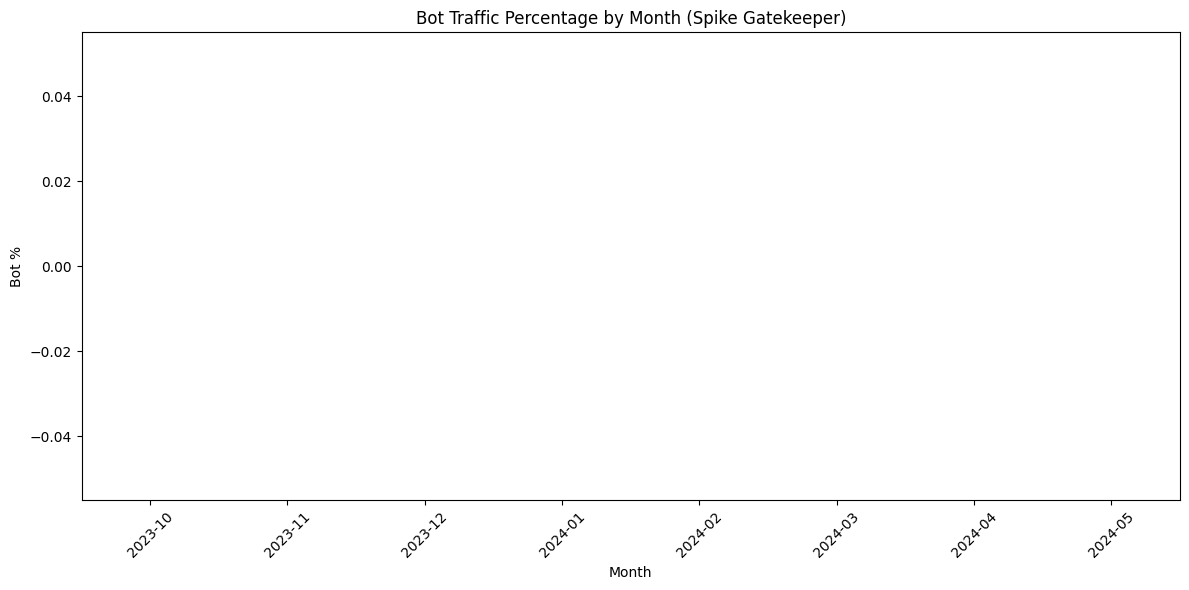


Running comprehensive detection on spike days...
Starting bot detection analysis on DataFrame with 1,737,545 rows...
Running complete detection with ML anomaly detection...
Starting time-based bot detection (spike threshold: 4.0x, signal threshold: 3+)...
Preparing data for analysis with time segmentation...
Prepared dataset with 1737545 rows spanning 3 months
Applying technical indicator rules...
Technical rules identified 103,847 bot sessions
Performing time-series analysis with spike threshold 4.0x...
Time-series analysis identified additional 0 bot sessions
Recorded 0 monthly spike patterns
Analyzing behavioral patterns by month...
Behavioral analysis identified additional 8,470 bot sessions across 3 months
Applying machine learning anomaly detection by month...

Processing ML detection for month: 2023-12
Found missing values in 2023-12. Applying imputation...
Running Isolation Forest for 2023-12...
Running Local Outlier Factor for 2023-12...
Running DBSCAN for 2023-12...
ML analy

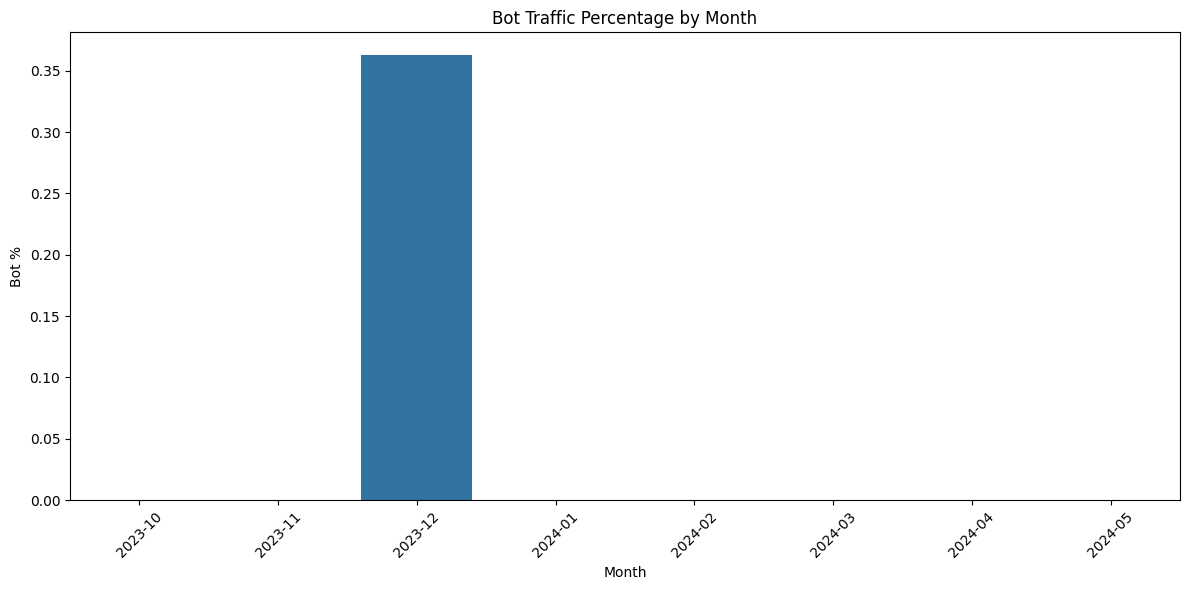


Bot detection workflow completed in 0:04:14.708247

Final Results:
Total rules: 1
Total sessions: 14,353,764
Bot sessions: 6,219 (0.04%)


In [322]:
result = run_complete_bot_detection(final_df)